# Predicting Property Damage in California from Historical Storm Data

<i>
Luis Otero
<br>
April 30, 2024
<br>
</i>

GitHub Link: https://github.com/otero106/BSAN6070

<img src = "https://bostonglobe-prod.cdn.arcpublishing.com/resizer/BFp_XmY93ECVkjZVnmHZU5gNNF0=/1440x0/cloudfront-us-east-1.images.arcpublishing.com/bostonglobe/ILQJW4B3FMTY57OYAGPL4XV7WA.jpg" alt = "image" width = 500 height = "auto">

## Table of Contents
* [Introduction](#intro)
* [Data](#data)
* [Python Implementation](#python)
    * [Importing and Combining the Data](#import_data)
    * [Data Exploration](#data_explore)
    * [Data Quality Report](#data_quality)
    * [Data Preprocessing](#data_preprocess)
    * [Data Visualizations After Cleaning](#data_viz)
    * [Performance Criteria for Models](#performance)
    * [Model Selection](#model_select)
    * [Model Assumption Validation](#model_valid)
    * [Creating Training and Testing Sets](#create_train)
    * [Model 1: Random Forest Regression](#model1)
    * [Model 2: Gradient Boosting Regression](#model2)
    * [Model 3: XGBoost Regressor](#model3)
    * [Conclusion](#conclusion)
    


## Introduction <a class="anchor" id="intro"></a>

### Background and Problem

In recent years, California has been marked by an escalation in the frequency and intensity of pervasive powerful storms, a trend that poses significant risks to property and livelihoods. The damaging effects these storms bring down on cities can be devastating as seen in early March this year in the southern region, with widespread flooding in San Diego and disastrous landslides in Los Angeles. In the San Francisco Bay Area, a historic two-day storm brought several inches of excessive rainfall and wind gusts up to 160 miles per hour, causing property damages ranging from nine to eleven billion dollars. The profound impact of the increased meteorological events, worsened by global climate change, emphasizes the need to effectively prepare for the financial repercussions of severe weather at an infrastructure level. In this case study, we focused on utilizing historic California storm data, provided by the National Center for Environmental Information, to predict the amount of future property damage. We looked specifically at severe weather episodes occurring in the inland counties and public forecast zones of California, as defined by the National Weather Service.

### Predictive Question

* Using historical storm data, can we effectively predict the amount of future property damage in California? 

* What are the top factors that can potentially contribute to higher property damage from a storm in California?  

### Usefulness of Predictive Question

 Accurate predictions can lead to better preparedness and more effective emergency responses. Knowing the potential scale of damage from impending storms can help emergency services to mobilize resources, prioritize areas for evacuation, and allocate emergency supplies more effectively. With improved forecasts, communities can take proactive safety measures to minimize the impact, such as reinforcing structures, securing potential flying debris, and implementing flood prevention strategies. Predicting the extent of damage can help governments and organizations to budget and allocate funds more effectively, reducing the economic strain on local and state resources. Long-term planning can be informed by damage predictions, prompting the construction of more resilient infrastructure in vulnerable areas. Policy makers can use predictive data to enforce building codes, adjust zoning laws, and implement land-use planning strategies to mitigate future damage.

## Data <a class="anchor" id="data"></a>

### Main Datasets
[Storm Data Dictionary](https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/Storm-Data-Bulk-csv-Format.pdf)

In this case study, we focused on utilizing historic California storm data, provided by the National Center for Environmental Information, to predict the amount of future property damage. The Storm Events Database is located on the website for the National Center for Environmental Information (NCEI), which is governed by the National Oceanic and Atmospheric Administration (NOAA). The database contains occurrences of storms and rare meteorological events across the US, and contains data that dates back as far as 1950. We looked specifically at severe weather episodes occurring in the inland counties and public forecast zones of California, as defined by the National Weather Service.

<b>
Data Overview:
</b>
<br><br>
Episodes: the dataset has many records of storm episodes, with different events occurring in those storms. 

Event Type examples:
- Strong wind
- Heavy rain 
- Flood
- Heavy snow
- Lightning

Time Features:
- Event year, month, day and time it started
- Day and time it ended

County or Zone
- Federal Info Processing Standards Designation of County or Zone where event occurred

Damage Property: the variable that we are going to predict, ranges from 0 to hundreds of millions of dollars

Latitude and Longitude of the beginning and end points of the event or damage path.

Narratives of Episodes and Events: provides descriptive details and overall activity of episode and event.

### Other Data

The storm events database was lacking key features that could potentially determine property damage including meteorological or weather-type, demographic, and geographical variables. To add more features to the dataset, we imported and joined demographic data such as county household units, county populations and city to county zone mappings, which we got from a public repository on the US Census Bureau and the California Department of Finance. To acquire more geographical features into our dataset, we used a public forecast zone and county dictionary from the National Weather Service, which also contained the coordinates of each zone, and also imported the land areas of each county from a public website called usa.com.

* [CA Dept. of Finance](https://dof.ca.gov/forecasting/demographics/estimates-e1/)
* [US Census Bureau](https://www2.census.gov/programs-surveys/popest/datasets/)
* [usa.com](http://www.usa.com/rank/california-state--land-area--city-rank.htm#google_vignette)
* [National Weather Service](https://www.weather.gov/gis/ZoneCounty)
* [Open Data Soft: US County Boundaries](https://public.opendatasoft.com/explore/dataset/us-county-boundaries/table/?flg=en-us&disjunctive.statefp&disjunctive.countyfp&disjunctive.name&disjunctive.namelsad&disjunctive.stusab&disjunctive.state_name)

## Python Implementation <a class="anchor" id="python"></a>

### Loading Modules <a class="anchor" id="load_modules"></a>

In [1]:
#import modules
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import os
import seaborn as sns
import glob
import plotly.express as px
import math
import xgboost as xg
from meteostat import Point, Hourly
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.model_selection import cross_validate

%matplotlib inline

### Importing and Combining the Data <a class="anchor" id="import_data"></a>

In [2]:
#read the path
file_path = "/Users/luisotero/Library/CloudStorage/OneDrive-lmu.edu/Documents/BSAN6070/storm_database/details"

#using glob to get all csv files
csv_files = glob.glob(os.path.join(file_path, "*.csv")) #use glob to get all csv file paths

csv_files

['/Users/luisotero/Library/CloudStorage/OneDrive-lmu.edu/Documents/BSAN6070/storm_database/details/details_2016.csv',
 '/Users/luisotero/Library/CloudStorage/OneDrive-lmu.edu/Documents/BSAN6070/storm_database/details/details_2017.csv',
 '/Users/luisotero/Library/CloudStorage/OneDrive-lmu.edu/Documents/BSAN6070/storm_database/details/details_2015.csv',
 '/Users/luisotero/Library/CloudStorage/OneDrive-lmu.edu/Documents/BSAN6070/storm_database/details/details_2014.csv',
 '/Users/luisotero/Library/CloudStorage/OneDrive-lmu.edu/Documents/BSAN6070/storm_database/details/details_2019.csv',
 '/Users/luisotero/Library/CloudStorage/OneDrive-lmu.edu/Documents/BSAN6070/storm_database/details/details_2018.csv',
 '/Users/luisotero/Library/CloudStorage/OneDrive-lmu.edu/Documents/BSAN6070/storm_database/details/details_2023.csv',
 '/Users/luisotero/Library/CloudStorage/OneDrive-lmu.edu/Documents/BSAN6070/storm_database/details/details_2022.csv',
 '/Users/luisotero/Library/CloudStorage/OneDrive-lmu.edu

In [3]:
#create empty list to store all file content
master_data = []

#use for loop to go through each csv file path
for file_path in csv_files:
    if file_path.endswith('.csv'):
        
        #read csv file
        file_data = pd.read_csv(file_path)

        #add dataset to list
        master_data.append(file_data)

#concatenating all datasets into one and saving it
storm_data = pd.concat(master_data)

#filter data to only include California
storm_data = storm_data[storm_data['STATE'] == 'CALIFORNIA']

### Data Exploration <a class="anchor" id="data_explore"></a>

In [4]:
#check number of rows and columns
storm_data.shape

(20486, 51)

In [5]:
#print first five rows of data
storm_data.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,...,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
278,201601,5,911,201601,5,1200,103037,615555,CALIFORNIA,6,...,1.0,S,DULAH,34.3083,-119.3459,34.3062,-119.3512,A powerful winter storm brought heavy rain and...,Heavy rainfall over the Solimar burn scar resu...,CSV
279,201601,5,1230,201601,5,1400,103037,615556,CALIFORNIA,6,...,2.0,N,GLENDORA,34.1526,-117.8708,34.1527,-117.8685,A powerful winter storm brought heavy rain and...,Heavy rainfall over the Colby burn scar result...,CSV
280,201601,6,1130,201601,6,1330,103037,615559,CALIFORNIA,6,...,2.0,SW,NEWHALL,34.3651,-118.5494,34.3622,-118.5488,A powerful winter storm brought heavy rain and...,Heavy rainfall over the Calgrove burn scar gen...,CSV
366,201601,5,1000,201601,6,2200,103037,615554,CALIFORNIA,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A powerful winter storm brought heavy rain and...,Significant winter storm conditions developed ...,CSV
368,201601,6,1056,201601,6,1100,103037,615561,CALIFORNIA,6,...,13.0,WNW,SUSANA KNOLLS,34.3971,-118.9214,34.3932,-118.9202,A powerful winter storm brought heavy rain and...,A severe thunderstorm moved across the communi...,CSV


In [6]:
#check column data types
storm_data.dtypes

BEGIN_YEARMONTH         int64
BEGIN_DAY               int64
BEGIN_TIME              int64
END_YEARMONTH           int64
END_DAY                 int64
END_TIME                int64
EPISODE_ID              int64
EVENT_ID                int64
STATE                  object
STATE_FIPS              int64
YEAR                    int64
MONTH_NAME             object
EVENT_TYPE             object
CZ_TYPE                object
CZ_FIPS                 int64
CZ_NAME                object
WFO                    object
BEGIN_DATE_TIME        object
CZ_TIMEZONE            object
END_DATE_TIME          object
INJURIES_DIRECT         int64
INJURIES_INDIRECT       int64
DEATHS_DIRECT           int64
DEATHS_INDIRECT         int64
DAMAGE_PROPERTY        object
DAMAGE_CROPS           object
SOURCE                 object
MAGNITUDE             float64
MAGNITUDE_TYPE         object
FLOOD_CAUSE            object
CATEGORY              float64
TOR_F_SCALE            object
TOR_LENGTH            float64
TOR_WIDTH 

In [7]:
#brief summary of data
storm_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20486 entries, 278 to 60828
Data columns (total 51 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   BEGIN_YEARMONTH     20486 non-null  int64  
 1   BEGIN_DAY           20486 non-null  int64  
 2   BEGIN_TIME          20486 non-null  int64  
 3   END_YEARMONTH       20486 non-null  int64  
 4   END_DAY             20486 non-null  int64  
 5   END_TIME            20486 non-null  int64  
 6   EPISODE_ID          20486 non-null  int64  
 7   EVENT_ID            20486 non-null  int64  
 8   STATE               20486 non-null  object 
 9   STATE_FIPS          20486 non-null  int64  
 10  YEAR                20486 non-null  int64  
 11  MONTH_NAME          20486 non-null  object 
 12  EVENT_TYPE          20486 non-null  object 
 13  CZ_TYPE             20486 non-null  object 
 14  CZ_FIPS             20486 non-null  int64  
 15  CZ_NAME             20486 non-null  object 
 16  WF

### Data Quality Report <a class="anchor" id="data_quality"></a>

In [8]:
#check for missing values
storm_data.isnull().sum()

BEGIN_YEARMONTH           0
BEGIN_DAY                 0
BEGIN_TIME                0
END_YEARMONTH             0
END_DAY                   0
END_TIME                  0
EPISODE_ID                0
EVENT_ID                  0
STATE                     0
STATE_FIPS                0
YEAR                      0
MONTH_NAME                0
EVENT_TYPE                0
CZ_TYPE                   0
CZ_FIPS                   0
CZ_NAME                   0
WFO                       0
BEGIN_DATE_TIME           0
CZ_TIMEZONE               0
END_DATE_TIME             0
INJURIES_DIRECT           0
INJURIES_INDIRECT         0
DEATHS_DIRECT             0
DEATHS_INDIRECT           0
DAMAGE_PROPERTY        2093
DAMAGE_CROPS           1861
SOURCE                    0
MAGNITUDE             15063
MAGNITUDE_TYPE        15404
FLOOD_CAUSE           16193
CATEGORY              20486
TOR_F_SCALE           20412
TOR_LENGTH            20412
TOR_WIDTH             20412
TOR_OTHER_WFO         20485
TOR_OTHER_CZ_STATE  

In [9]:
#check for duplicate rows
duplicate = storm_data[storm_data.duplicated()]

#number of duplicate rows
print('Number of duplicate rows:', duplicate.shape[0])

Number of duplicate rows: 0


#### Descriptive and Summary Statistics

In [10]:
#descriptive statistics on numerical columns
round(storm_data.describe(),2)

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE_FIPS,YEAR,...,CATEGORY,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_CZ_FIPS,BEGIN_RANGE,END_RANGE,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON
count,20486.00,20486.00,20486.00,20486.00,20486.00,20486.00,20486.00,20486.00,20486.0,20486.00,...,0.0,74.00,74.00,1.0,6436.00,6436.00,6436.00,6436.00,6436.00,6436.00
mean,201947.60,14.21,989.37,201947.60,17.16,1372.46,143016.97,863377.62,6.0,2019.42,...,NaN,1.17,54.91,71.0,2.92,2.92,36.65,-119.65,36.65,-119.65
std,272.31,9.26,680.31,272.31,9.28,667.43,28765.68,178190.01,0.0,2.73,...,NaN,2.04,115.09,NaN,5.49,5.49,2.23,2.38,2.23,2.38
min,201401.00,1.00,0.00,201401.00,1.00,0.00,80664.00,482935.00,6.0,2014.00,...,NaN,0.01,1.00,71.0,0.00,0.00,32.54,-124.40,32.54,-124.40
25%,201709.00,6.00,400.00,201709.00,9.00,800.00,119730.00,718317.50,6.0,2017.00,...,NaN,0.19,11.25,71.0,1.00,1.00,34.59,-121.83,34.57,-121.84
50%,202001.00,14.00,1000.00,202001.00,17.00,1400.00,145463.00,873935.50,6.0,2020.00,...,NaN,0.46,25.00,71.0,2.00,2.00,36.91,-119.79,36.91,-119.79
75%,202204.00,22.00,1515.00,202204.00,26.00,1901.00,168362.50,1020957.75,6.0,2022.00,...,NaN,0.99,50.00,71.0,3.00,3.00,38.35,-117.53,38.35,-117.51
max,202312.00,31.00,2359.00,202312.00,31.00,2359.00,187863.00,1153800.00,6.0,2023.00,...,NaN,12.02,900.00,71.0,122.00,122.00,41.91,-114.20,41.90,-114.20


In [11]:
#descriptive statistics on categorical columns
storm_data.describe(include='object')

,STATE,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,DAMAGE_PROPERTY,...,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_NAME,BEGIN_AZIMUTH,BEGIN_LOCATION,END_AZIMUTH,END_LOCATION,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
count,20486,20486,20486,20486,20486,20486,20486,20486,20486,18393,...,1,1,1,6436,6436,6436,6436,20486,19601,20486
unique,1,12,38,2,307,10,13173,3,13154,155,...,1,1,1,16,1970,16,1975,3401,16775,1
top,CALIFORNIA,January,High Wind,Z,SAN BERNARDINO,HNX,01-SEP-22 00:00:00,PST-8,31-AUG-22 23:59:00,0.00K,...,VEF,CA,SAN BERNARDINO,N,SAN FRANCISCO,N,SAN FRANCISCO,A strong low pressure system moved through cen...,Persistent drought conditions continued to be ...,CSV
freq,20486,3817,3338,14049,696,7045,113,20408,92,15908,...,1,1,1,783,61,681,59,232,110,20486


In [12]:
#display unique values and their counts for each categorical column
for column in storm_data.select_dtypes(include='object').columns:
    print(column)
    print(storm_data[column].value_counts())
    print('–––––––––––––––––––––––––––––––––––––––––––––––––––––––\n')

STATE
CALIFORNIA    20486
Name: STATE, dtype: int64
–––––––––––––––––––––––––––––––––––––––––––––––––––––––

MONTH_NAME
January      3817
February     2789
December     2787
March        2010
November     1643
August       1333
July         1225
October      1088
September    1082
April        1041
June          874
May           797
Name: MONTH_NAME, dtype: int64
–––––––––––––––––––––––––––––––––––––––––––––––––––––––

EVENT_TYPE
High Wind                  3338
Flood                      2446
Drought                    1543
Heavy Snow                 1467
Dense Fog                  1385
Strong Wind                1349
Flash Flood                1268
Excessive Heat             1105
Heavy Rain                 1084
Winter Weather              921
Frost/Freeze                686
Heat                        666
Debris Flow                 579
Wildfire                    539
Winter Storm                420
Thunderstorm Wind           395
Hail                        341
High Surf            

In [13]:
#display percentage of unique values for each column as % format
for col in storm_data.select_dtypes(include='object').columns:
    print(storm_data[col].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')
    print('–––––––––––––––––––––––––––––––––––––––-')

CALIFORNIA    100.0%
Name: STATE, dtype: object
–––––––––––––––––––––––––––––––––––––––-
January      18.6%
February     13.6%
December     13.6%
March         9.8%
November      8.0%
August        6.5%
July          6.0%
October       5.3%
September     5.3%
April         5.1%
June          4.3%
May           3.9%
Name: MONTH_NAME, dtype: object
–––––––––––––––––––––––––––––––––––––––-
High Wind                  16.3%
Flood                      11.9%
Drought                     7.5%
Heavy Snow                  7.2%
Dense Fog                   6.8%
Strong Wind                 6.6%
Flash Flood                 6.2%
Excessive Heat              5.4%
Heavy Rain                  5.3%
Winter Weather              4.5%
Frost/Freeze                3.3%
Heat                        3.3%
Debris Flow                 2.8%
Wildfire                    2.6%
Winter Storm                2.1%
Thunderstorm Wind           1.9%
Hail                        1.7%
High Surf                   1.1%
Funnel Cloud    

In [14]:
#pivot table of count of event type by year
pivot_table = storm_data.pivot_table(index='EVENT_TYPE', columns='YEAR', values='DAMAGE_PROPERTY', aggfunc='count')
pivot_table

YEAR,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
EVENT_TYPE,,,,,,,,,,
Astronomical Low Tide,NaN,NaN,1.0,NaN,1.0,2.0,1.0,11.0,NaN,NaN
Avalanche,NaN,1.0,2.0,1.0,1.0,1.0,0.0,2.0,1.0,13.0
Blizzard,NaN,NaN,NaN,0.0,0.0,1.0,NaN,2.0,NaN,4.0
Coastal Flood,7.0,12.0,2.0,2.0,3.0,6.0,9.0,7.0,3.0,10.0
Cold/Wind Chill,NaN,1.0,NaN,NaN,2.0,12.0,3.0,5.0,7.0,9.0
Debris Flow,22.0,20.0,19.0,149.0,73.0,125.0,14.0,60.0,51.0,46.0
Dense Fog,62.0,93.0,102.0,64.0,127.0,160.0,173.0,239.0,154.0,69.0
Dense Smoke,NaN,NaN,NaN,NaN,25.0,2.0,3.0,NaN,1.0,NaN
Drought,133.0,152.0,33.0,7.0,NaN,NaN,1.0,349.0,606.0,19.0


In [15]:
#convert DAMAGE_PROPERTY to numeric
storm_data['DAMAGE_PROPERTY'] = storm_data['DAMAGE_PROPERTY'].str.replace('K', 'e3').str.replace('M', 'e6')
storm_data['DAMAGE_PROPERTY'] = pd.to_numeric(storm_data['DAMAGE_PROPERTY'], errors='coerce')

#display number of zeroes in property damage column and percentage
print('Number of zeroes in property damage column:', storm_data['DAMAGE_PROPERTY'].value_counts()[0]) 
print('Percentage of zeroes in property damage column:', round(storm_data['DAMAGE_PROPERTY'].value_counts(normalize=True)[0]*100,2))

Number of zeroes in property damage column: 15909
Percentage of zeroes in property damage column: 86.5


In [16]:
#pivot table of property damage by event type and year
measures = ['sum']
pivot_table2 = storm_data.pivot_table(index='EVENT_TYPE', columns='YEAR', values='DAMAGE_PROPERTY', aggfunc= measures)
pivot_table2

sum                                       \
YEAR                           2014        2015        2016         2017   
EVENT_TYPE                                                                 
Astronomical Low Tide           NaN         NaN         0.0          NaN   
Avalanche                       NaN         0.0         0.0          0.0   
Blizzard                        NaN         NaN         NaN          0.0   
Coastal Flood               15000.0         0.0         0.0      35000.0   
Cold/Wind Chill                 NaN         0.0         NaN          NaN   
Debris Flow               2362000.0    122000.0     15000.0   25856000.0   
Dense Fog                  200000.0    100000.0    115000.0     324000.0   
Dense Smoke                     NaN         NaN         NaN          NaN   
Drought                         0.0         0.0         0.0          0.0   
Dust Devil                   6000.0         NaN         NaN          NaN   
Dust Storm                 268000.0         0.0         0.0     145000.0   
Excessive Heat                  0.0         NaN         0.0      10000.0   
Extreme Cold/Wind Chill         NaN         NaN         0.0          0.0   
Flash Flood              13619800.0  80021000.0    825500.0   14766200.0   
Flood                     1296500.0    193000.0   2179700.0  609042190.0   
Freezing Fog                    NaN         NaN         NaN          NaN   
Frost/Freeze                    0.0    300000.0         0.0          0.0   
Funnel Cloud                    0.0         0.0         0.0          0.0   
Hail                          500.0      5100.0     30110.0   20001130.0   
Heat                            0.0         0.0         0.0          0.0   
Heavy Rain                  26000.0     96000.0   2940000.0   82846000.0   
Heavy Snow                  43000.0     29000.0      8000.0      11000.0   
High Surf                40000000.0         0.0   8360000.0          0.0   
High Wind                 3621500.0     66500.0    910500.0   10509000.0   
Ice Storm                       NaN         NaN         0.0      55000.0   
Lake-Effect Snow                NaN         NaN         NaN          NaN   
Lightning                   29500.0     62000.0   1054500.0     295030.0   
Rip Current                     0.0         NaN         0.0          0.0   
Sneakerwave                     0.0         0.0         0.0          NaN   
Storm Surge/Tide                NaN         NaN         NaN          NaN   
Strong Wind               4015700.0   2145800.0   1536100.0    2999000.0   
Thunderstorm Wind         4129000.0   3405000.0    632600.0    3579000.0   
Tornado                         0.0  20025000.0       500.0      25000.0   
Tropical Storm                  NaN         NaN         NaN          NaN   
Tsunami                         NaN         0.0         NaN          NaN   
Wildfire                 57172000.0   1956000.0  55550000.0   96400000.0   
Winter Storm                 5000.0         0.0         0.0          0.0   
Winter Weather              22000.0         0.0         0.0      50000.0   

                                                                            \
YEAR                            2018         2019        2020         2021   
EVENT_TYPE                                                                   
Astronomical Low Tide            0.0          0.0         0.0          0.0   
Avalanche                        0.0          0.0         0.0     250000.0   
Blizzard                         0.0          0.0         NaN          0.0   
Coastal Flood                    0.0          0.0     40000.0          0.0   
Cold/Wind Chill                  0.0          0.0         0.0          0.0   
Debris Flow              618058000.0     120000.0   2030000.0    4606200.0   
Dense Fog                   100000.0     315000.0    150000.0     800000.0   
Dense Smoke                      0.0          0.0         0.0          NaN   
Drought                          NaN          NaN        

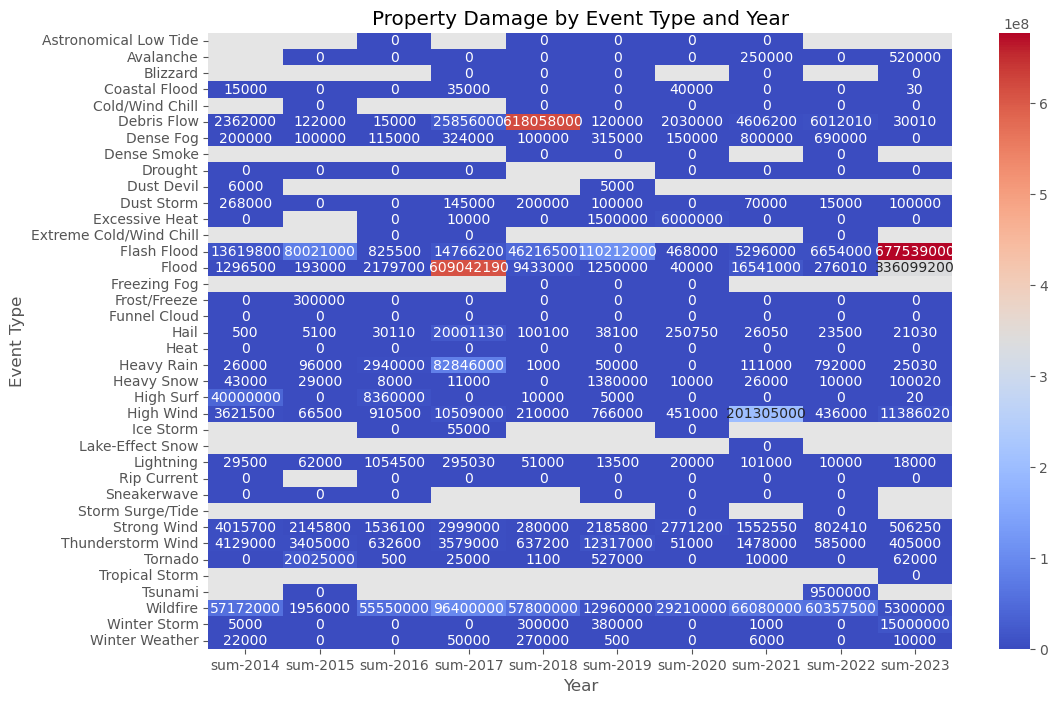

In [17]:
#heatmap of pivot table
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
sns.heatmap(pivot_table2, cmap='coolwarm', annot=True, fmt=".0f")
plt.title('Property Damage by Event Type and Year')
plt.ylabel('Event Type')
plt.xlabel('Year')
plt.show()

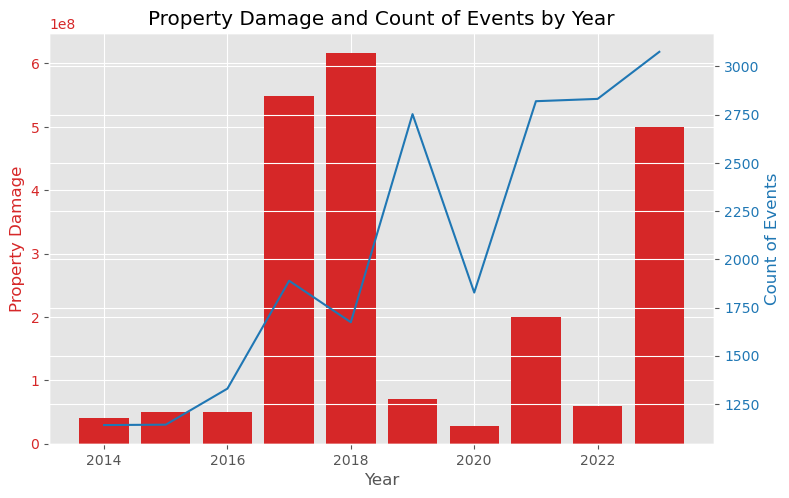

In [18]:
#bar and line chart of property_damage and count of events by year
plt.style.use('ggplot')
fig, ax1 = plt.subplots(figsize=(8,5))
color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Property Damage', color=color)
ax1.bar(storm_data['YEAR'], storm_data['DAMAGE_PROPERTY'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Count of Events', color=color)
ax2.plot(storm_data['YEAR'].value_counts().sort_index(), color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.title('Property Damage and Count of Events by Year')
plt.show()

#### Univariate Analysis

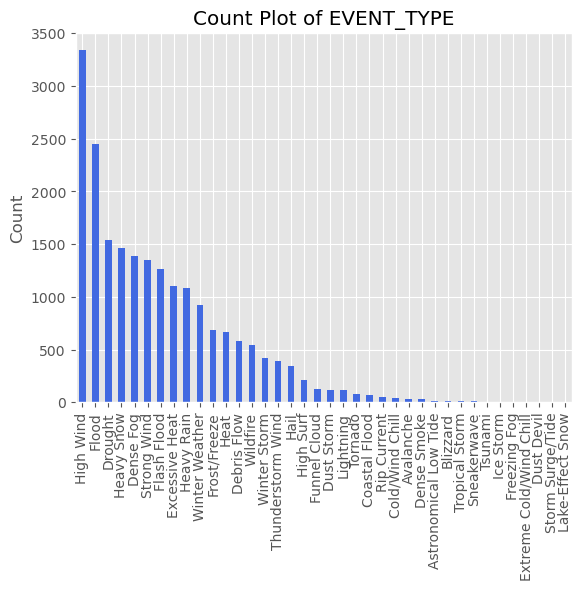

<Figure size 800x500 with 0 Axes>

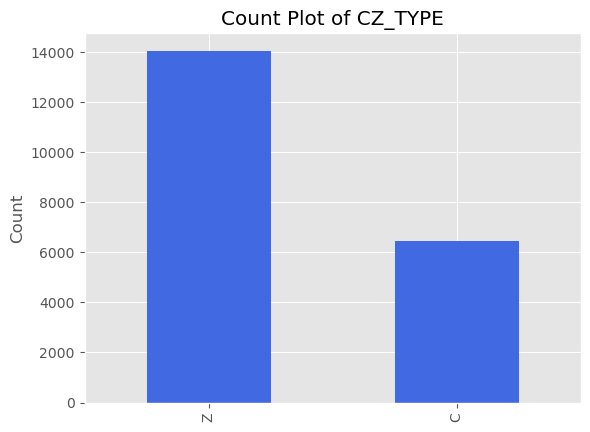

<Figure size 800x500 with 0 Axes>

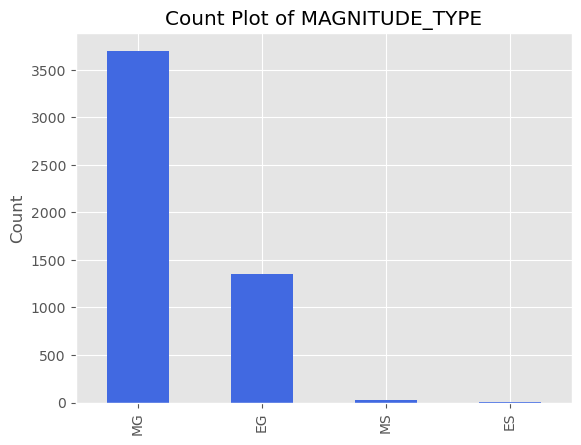

<Figure size 800x500 with 0 Axes>

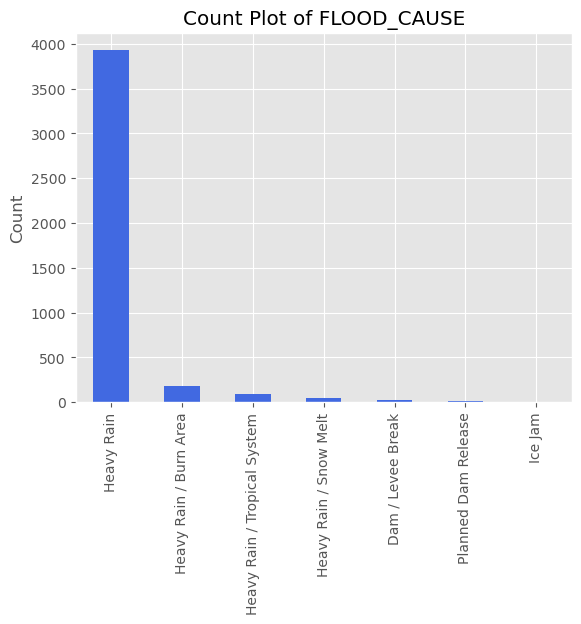

<Figure size 800x500 with 0 Axes>

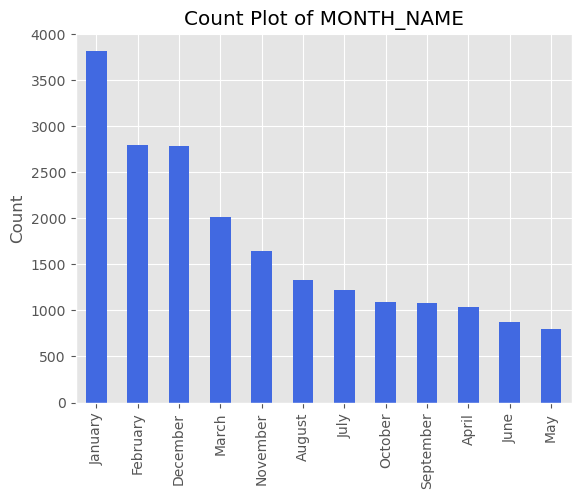

<Figure size 800x500 with 0 Axes>

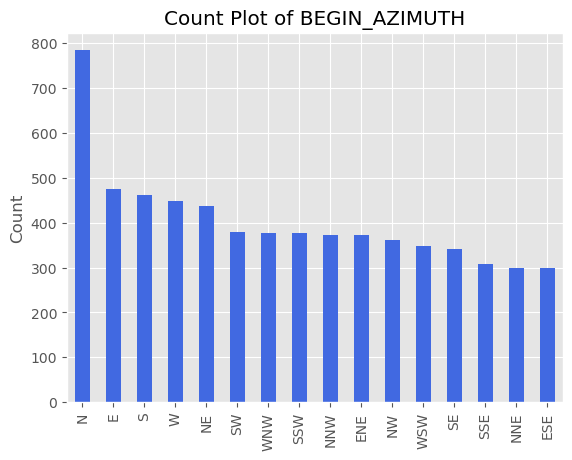

<Figure size 800x500 with 0 Axes>

In [19]:
#visualize distribution of each categorical column using bar charts
plt.style.use('ggplot')

cat_col_list = ['EVENT_TYPE', 'CZ_TYPE', 'MAGNITUDE_TYPE', 'FLOOD_CAUSE', 'MONTH_NAME', 'BEGIN_AZIMUTH']

for col in cat_col_list:
    storm_data[col].value_counts().plot(kind='bar', ylabel='Count', color = 'royalblue')
    plt.title("Count Plot of " + col)
    plt.figure(figsize=(8,5))
    plt.show()

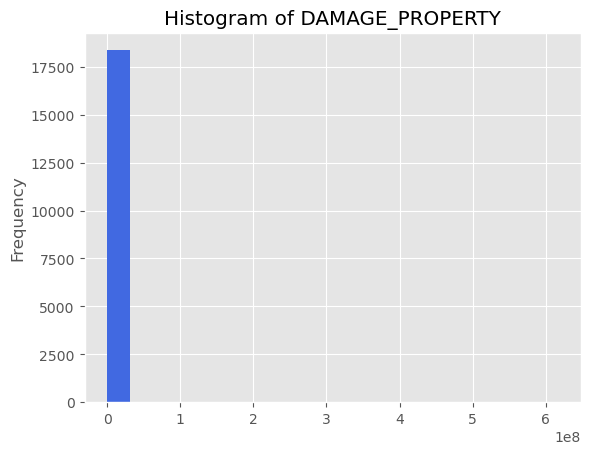

<Figure size 800x500 with 0 Axes>

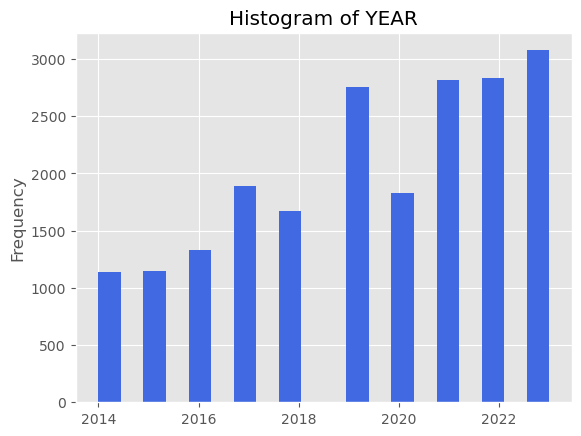

<Figure size 800x500 with 0 Axes>

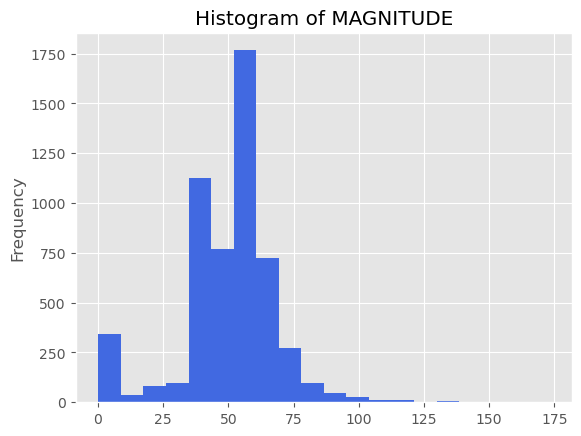

<Figure size 800x500 with 0 Axes>

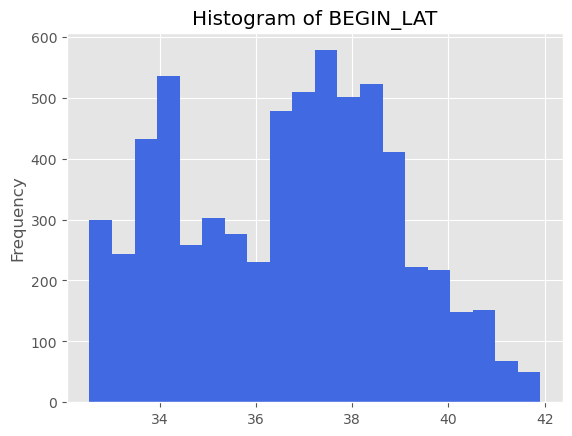

<Figure size 800x500 with 0 Axes>

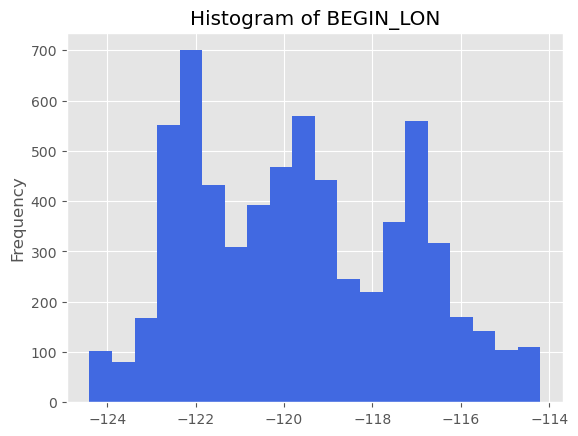

<Figure size 800x500 with 0 Axes>

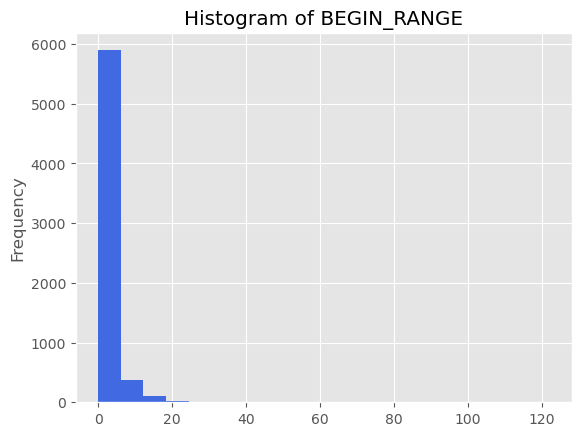

<Figure size 800x500 with 0 Axes>

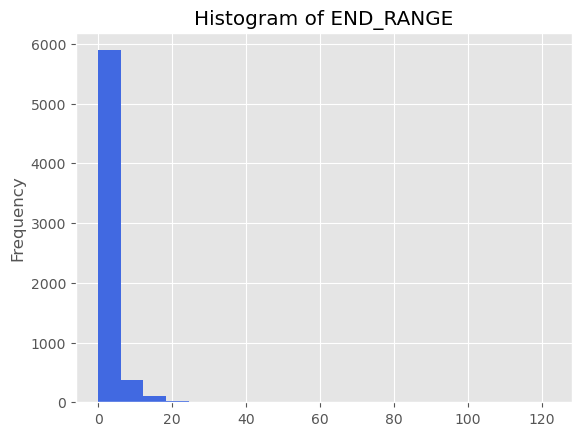

<Figure size 800x500 with 0 Axes>

In [20]:
#histogram of numerical columns
plt.style.use('ggplot')

num_col_list = ['DAMAGE_PROPERTY', 'YEAR', 'MAGNITUDE', 'BEGIN_LAT', 'BEGIN_LON', 'BEGIN_RANGE', 'END_RANGE']

for col in num_col_list:
    storm_data[col].plot(kind='hist', bins=20, color = 'royalblue')
    plt.title("Histogram of " + col)
    plt.figure(figsize=(8,5))
    plt.show()

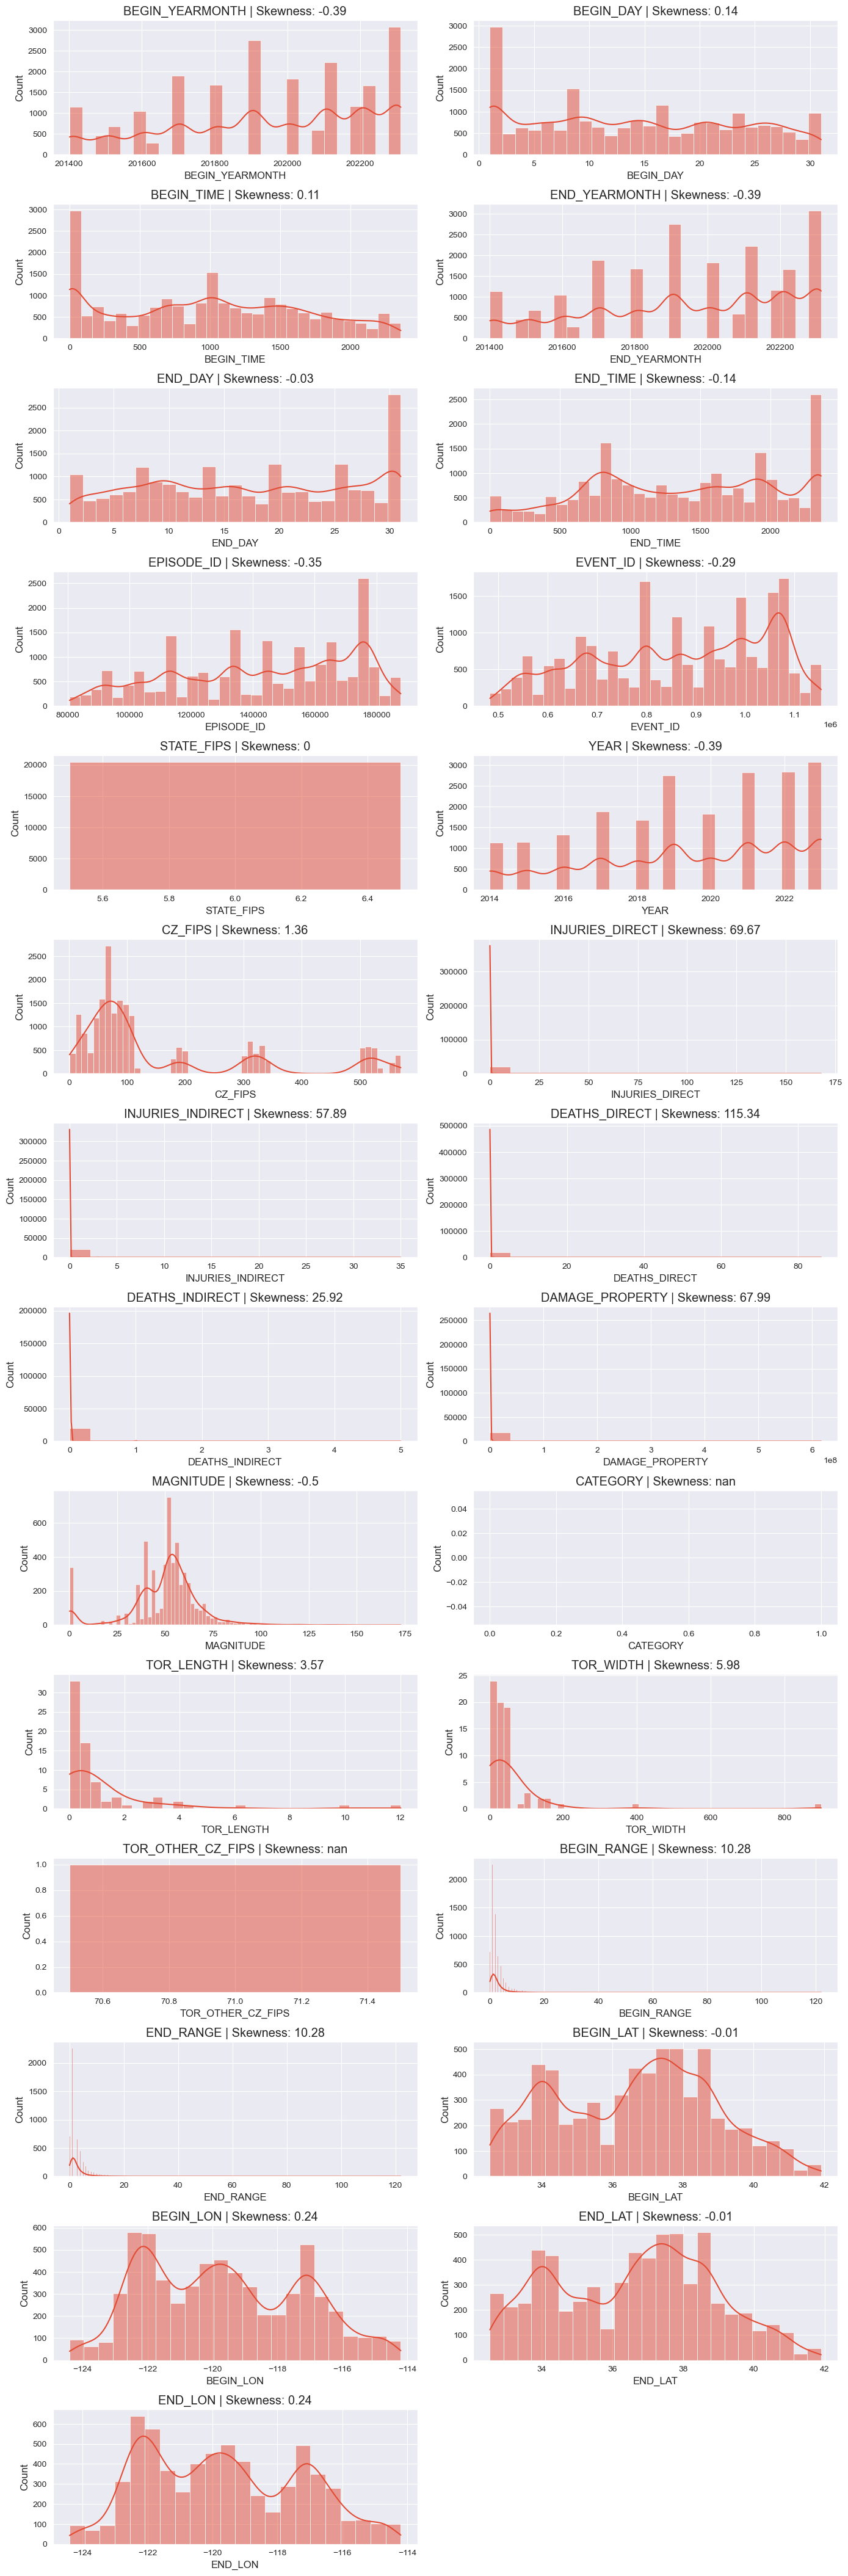

In [21]:
#density plots
#set seaborn style
sns.set_style("darkgrid")
 
#identify numerical columns
numerical_columns = storm_data.select_dtypes(include=["int64", "float64"]).columns
 
#plot distribution of each numerical feature
plt.figure(figsize=(14, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, idx)
    sns.histplot(storm_data[feature], kde=True)
    plt.title(f"{feature} | Skewness: {round(storm_data[feature].skew(), 2)}")
 
#adjust layout and show plots
plt.tight_layout()
plt.show()

#### Bivariate Analysis

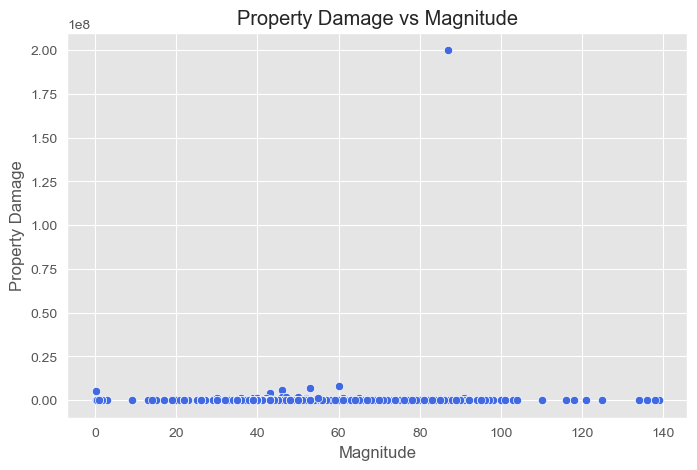

In [22]:
#scatter plot of property damage and magnitude
plt.style.use('ggplot')
plt.figure(figsize=(8,5))
sns.scatterplot(x='MAGNITUDE', y='DAMAGE_PROPERTY', data=storm_data, color='royalblue')
plt.title('Property Damage vs Magnitude')
plt.xlabel('Magnitude')
plt.ylabel('Property Damage')
plt.show()

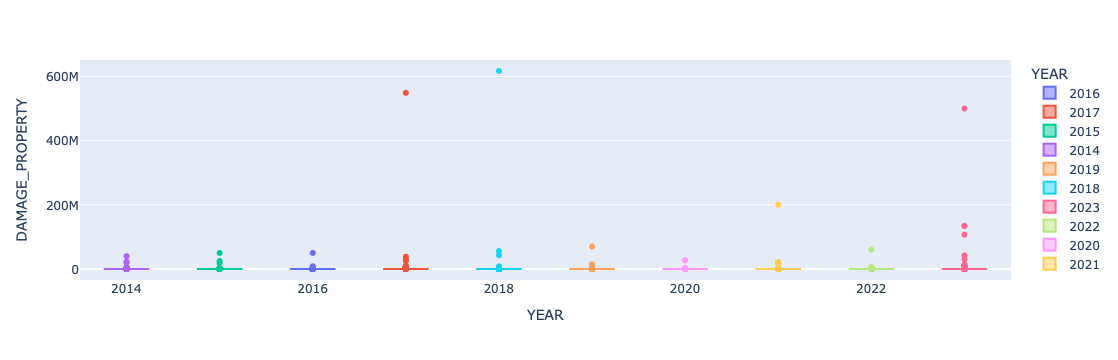

In [23]:
#check for outliers in damage_property with box plot
px.box(storm_data, x = 'YEAR', y = 'DAMAGE_PROPERTY', color = 'YEAR', points = 'outliers')

#### Multivariate Analysis

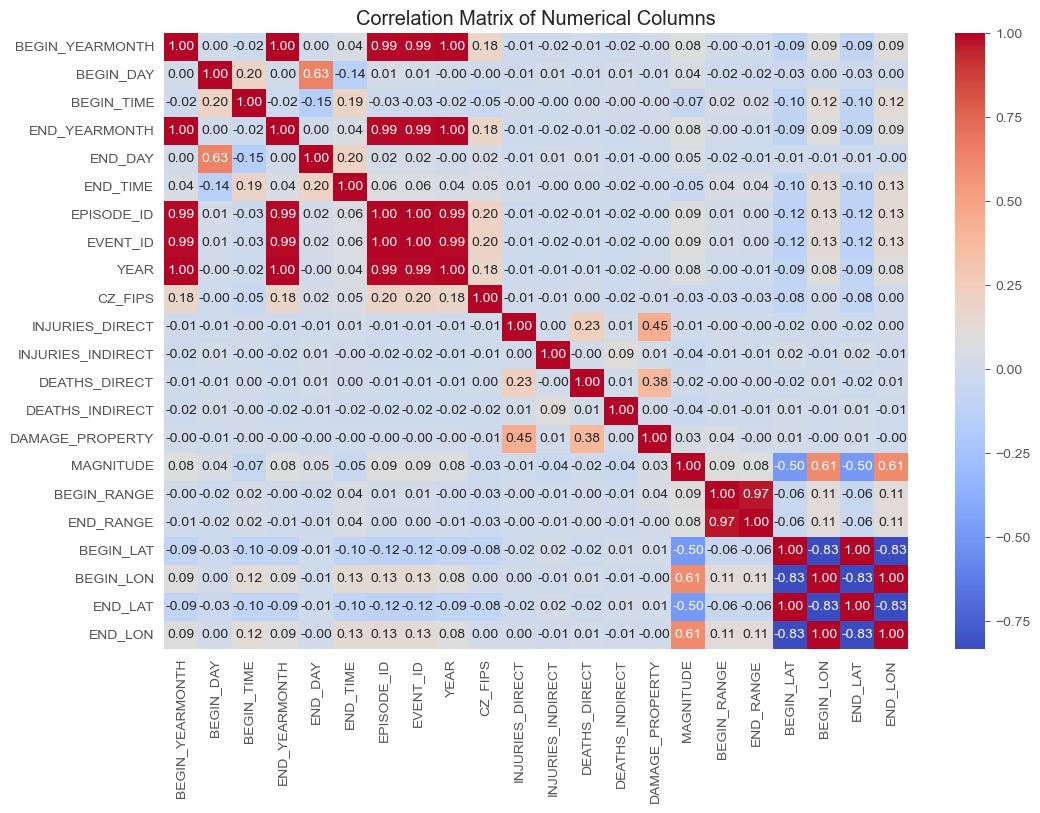

In [24]:
#correlation matrix of numerical columns

#store all numerical columns
numerical_columns = storm_data.select_dtypes(include=['int64', 'float64']).columns

#drop columns that are not needed
numerical_columns = numerical_columns.drop(['STATE_FIPS', 'CATEGORY', 'TOR_LENGTH', 'TOR_WIDTH', 'TOR_OTHER_CZ_FIPS'])

#correlation matrix
plt.figure(figsize=(12,8))
sns.heatmap(storm_data[numerical_columns].corr(), cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Matrix of Numerical Columns')
plt.show()

### Data Preprocessing <a class="anchor" id="data_preprocess"></a>

#### Removing Irrelevant Columns

In [25]:
#remove columns that are not needed
drop_columns = ['STATE', 'STATE_FIPS', 'WFO', 'CZ_TIMEZONE', 'DAMAGE_CROPS', 'SOURCE', 'CATEGORY', 'TOR_F_SCALE', 'TOR_LENGTH', 
                'TOR_WIDTH', 'TOR_OTHER_WFO', 'TOR_OTHER_CZ_STATE', 'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME','DATA_SOURCE', 'MAGNITUDE_TYPE',
                'FLOOD_CAUSE', 'BEGIN_YEARMONTH', 'END_YEARMONTH', 'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT', 'DEATHS_INDIRECT']

storm_data_copy = storm_data.drop(drop_columns, axis=1)

#make all column names lowercase
storm_data_copy.columns = storm_data_copy.columns.str.lower()

storm_data_copy.columns

Index(['begin_day', 'begin_time', 'end_day', 'end_time', 'episode_id',
       'event_id', 'year', 'month_name', 'event_type', 'cz_type', 'cz_fips',
       'cz_name', 'begin_date_time', 'end_date_time', 'damage_property',
       'magnitude', 'begin_range', 'begin_azimuth', 'begin_location',
       'end_range', 'end_azimuth', 'end_location', 'begin_lat', 'begin_lon',
       'end_lat', 'end_lon', 'episode_narrative', 'event_narrative'],
      dtype='object')

#### Converting Columns

In [26]:
#convert datetime columns to datetime format
storm_data_copy['begin_date_time'] = pd.to_datetime(storm_data_copy['begin_date_time'])
storm_data_copy['end_date_time'] = pd.to_datetime(storm_data_copy['end_date_time'])

#convert month_name to month number
month_dict = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}

storm_data_copy['month_name'] = storm_data_copy['month_name'].map(month_dict)

#rename month_name to month
storm_data_copy.rename(columns={'month_name': 'month'}, inplace=True)

#### Removing Irrelevant Event Types

In [27]:
#remove event types that are irrelevant
storm_data_copy = storm_data_copy[~storm_data_copy['event_type'].isin(['Sneakerwave', 'Dust Devil', 'Frost/Freeze', 'Dust Storm', 'Dense Smoke', 'Funnel Cloud',
                                                                       'Drought', 'Heat', 'Excessive Heat', 'Astronomical Low Tide', 'Freezing Fog', 'Ice Storm',
                                                                       'Tropical Storm', 'Tornado', 'Tsunami', 'Strong Surge/Tide', 'Lake-Effect Snow', 'Extreme Cold/Wind Chill',
                                                                       'Dense Smoke', 'Cold/Wind Chill', 'Blizzard', 'Avalanche', 'Rip Current', 'Storm Surge/Tide'])]

#### Feature Encoding

In [28]:
#categorical columns
storm_data_copy.select_dtypes(include='object').columns

Index(['event_type', 'cz_type', 'cz_name', 'begin_azimuth', 'begin_location',
       'end_azimuth', 'end_location', 'episode_narrative', 'event_narrative'],
      dtype='object')

In [29]:
#one-hot encoding on event type
storm_data_copy = pd.get_dummies(storm_data_copy, columns=['event_type'], drop_first=True)

#one-hot encoding on begin_azimuth
storm_data_copy = pd.get_dummies(storm_data_copy, columns=['begin_azimuth'], drop_first=True)

#one-hot encoding on end_azimuth
storm_data_copy = pd.get_dummies(storm_data_copy, columns=['end_azimuth'], drop_first=True)

In [30]:
#display columns that have event type in title
event_type_columns = [col for col in storm_data_copy.columns if 'azimuth' in col]
event_type_columns

['begin_azimuth_ENE',
 'begin_azimuth_ESE',
 'begin_azimuth_N',
 'begin_azimuth_NE',
 'begin_azimuth_NNE',
 'begin_azimuth_NNW',
 'begin_azimuth_NW',
 'begin_azimuth_S',
 'begin_azimuth_SE',
 'begin_azimuth_SSE',
 'begin_azimuth_SSW',
 'begin_azimuth_SW',
 'begin_azimuth_W',
 'begin_azimuth_WNW',
 'begin_azimuth_WSW',
 'end_azimuth_ENE',
 'end_azimuth_ESE',
 'end_azimuth_N',
 'end_azimuth_NE',
 'end_azimuth_NNE',
 'end_azimuth_NNW',
 'end_azimuth_NW',
 'end_azimuth_S',
 'end_azimuth_SE',
 'end_azimuth_SSE',
 'end_azimuth_SSW',
 'end_azimuth_SW',
 'end_azimuth_W',
 'end_azimuth_WNW',
 'end_azimuth_WSW']

#### Grouping Data

In [31]:
#group data by episode_id and cz_name and keep all columns, including categorical columns
storm_data_grouped = storm_data_copy.groupby(['episode_id', 'cz_name']).agg({
    'begin_day' : 'max', 'begin_time' : 'first', 'end_day' : 'max', 'end_time' : 'last', 'event_id' : 'max', 'year' : 'max', 
    'month' : 'max', 'cz_type' : 'first', 'cz_fips' : 'first', 'begin_date_time' : 'first', 'end_date_time' : 'last', 
    'damage_property' : 'sum', 'magnitude' : 'max', 'begin_range' : 'max', 'begin_location' : 'first', 'end_range' : 'max',
    'end_location' : 'last', 'begin_lat' : 'first', 'begin_lon' : 'first', 'end_lat' : 'last', 'end_lon' : 'last', 'episode_narrative' : 'first', 'event_narrative' : 'first',
    'event_type_Debris Flow' : 'max', 'event_type_Dense Fog' : 'max', 'event_type_Flash Flood' : 'max', 'event_type_Flood' : 'max', 'event_type_Hail' : 'max', 'event_type_Heavy Rain' : 'max', 
    'event_type_Heavy Snow' : 'max', 'event_type_High Surf' : 'max', 'event_type_High Wind' : 'max', 'event_type_Lightning' : 'max', 'event_type_Strong Wind' : 'max', 'event_type_Thunderstorm Wind' : 'max', 
    'event_type_Wildfire' : 'max', 'event_type_Flood' : 'max', 'event_type_Hail' : 'max', 'event_type_Heavy Rain' : 'max', 'event_type_Heavy Snow' : 'max', 'event_type_High Surf' : 'max', 'event_type_High Wind' : 'max', 
    'event_type_Lightning' : 'max', 'event_type_Strong Wind' : 'max', 'event_type_Thunderstorm Wind' : 'max', 'event_type_Wildfire' : 'max', 'event_type_Winter Storm' : 'max', 'event_type_Winter Weather' : 'max',
    'begin_azimuth_ENE' : 'first', 'begin_azimuth_ESE': 'first', 'begin_azimuth_N' : 'first', 'begin_azimuth_NE' : 'first', 'begin_azimuth_NNE' : 'first', 'begin_azimuth_NNW' : 'first', 'begin_azimuth_NW' : 'first',
    'begin_azimuth_S' : 'first', 'begin_azimuth_SE' : 'first', 'begin_azimuth_SSE' : 'first', 'begin_azimuth_SSW' : 'first', 'begin_azimuth_SW' : 'first', 'begin_azimuth_W' : 'first', 'begin_azimuth_WNW' : 'first', 
    'begin_azimuth_WSW' : 'first', 'end_azimuth_ENE' : 'first', 'end_azimuth_ESE' : 'first', 'end_azimuth_N' : 'first', 'end_azimuth_NE' : 'first', 'end_azimuth_NNE' : 'first', 'end_azimuth_NNW' : 'first', 'end_azimuth_NW' : 'first',
    'end_azimuth_S' : 'first', 'end_azimuth_SE' : 'first', 'end_azimuth_SSE' : 'first', 'end_azimuth_SSW' : 'first', 'end_azimuth_SW' : 'first', 'end_azimuth_W' : 'first', 'end_azimuth_WNW' : 'first', 'end_azimuth_WSW' : 'first'
    }).reset_index()

storm_data_grouped.head()

,episode_id,cz_name,begin_day,begin_time,end_day,end_time,event_id,year,month,cz_type,...,end_azimuth_NNW,end_azimuth_NW,end_azimuth_S,end_azimuth_SE,end_azimuth_SSE,end_azimuth_SSW,end_azimuth_SW,end_azimuth_W,end_azimuth_WNW,end_azimuth_WSW
0,80664,OWENS VALLEY,11,1542,11,2342,482935,2014,1,Z,...,0,0,0,0,0,0,0,0,0,0
1,81273,NORTH CENTRAL & SOUTHEAST SISKIYOU COUNTY,7,1200,7,2200,487385,2014,2,Z,...,0,0,0,0,0,0,0,0,0,0
2,81273,SOUTH CENTRAL SISKIYOU COUNTY,7,1200,7,2200,487384,2014,2,Z,...,0,0,0,0,0,0,0,0,0,0
3,81273,WESTERN SISKIYOU COUNTY,7,1200,7,2200,487386,2014,2,Z,...,0,0,0,0,0,0,0,0,0,0
4,81827,MODOC COUNTY,15,1203,15,1803,491276,2014,2,Z,...,0,0,0,0,0,0,0,0,0,0


#### Create Time Columns

In [32]:
#drop time columns
storm_data_grouped.drop(['begin_time', 'end_time'], axis=1, inplace=True)

In [33]:
#generate hour of day from begin_date_time
storm_data_grouped['begin_hour_of_day'] = storm_data_grouped['begin_date_time'].dt.hour

#generate end hour of day from end_date_time
storm_data_grouped['end_hour_of_day'] = storm_data_grouped['end_date_time'].dt.hour

In [34]:
#create quarter bins
storm_data_grouped['quarter'] = storm_data_grouped['begin_date_time'].dt.quarter

#create time of day bins
def time_of_day(hour):
    if hour >= 0 and hour < 6:
        return 'Late Night'
    elif hour >= 6 and hour < 12:
        return 'Morning'
    elif hour >= 12 and hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'
    
storm_data_grouped['time_of_day'] = storm_data_grouped['begin_date_time'].dt.hour.apply(time_of_day)

#create day of week bins
def day_of_week(day):
    if day == 0:
        return 'Monday'
    elif day == 1:
        return 'Tuesday'
    elif day == 2:
        return 'Wednesday'
    elif day == 3:
        return 'Thursday'
    elif day == 4:
        return 'Friday'
    elif day == 5:
        return 'Saturday'
    else:
        return 'Sunday'
    
storm_data_grouped['day_of_week'] = storm_data_grouped['begin_date_time'].dt.dayofweek.apply(day_of_week)

In [35]:
#one-hot encoding on time of day
storm_data_grouped = pd.get_dummies(storm_data_grouped, columns=['time_of_day'], drop_first=True)

#one-hot encoding on day of week
storm_data_grouped = pd.get_dummies(storm_data_grouped, columns=['day_of_week'], drop_first=True)

In [36]:
#drop narrative columns
storm_data_grouped.drop(['episode_narrative', 'event_narrative'], axis=1, inplace=True)

#### Removing Outliers and Transforming the Zeroes in Predictor Column

In [37]:
#transform 0s in damage_property to 1
storm_data_grouped['damage_property'] = storm_data_grouped['damage_property'].replace(0, 1)


storm_data_grouped.shape

(8253, 78)

In [38]:
#get rid of outliers with z-score
z_scores = stats.zscore(storm_data_grouped['damage_property'])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3)
storm_data_filtered = storm_data_grouped[filtered_entries]

storm_data_filtered.shape

(8237, 78)

#### Dealing with Missing Values

In [39]:
#check for missing values in each column
for col in storm_data_filtered.columns:
    if storm_data_filtered[col].isnull().sum() > 0:
        print(col, storm_data_filtered[col].isnull().sum())

magnitude 4811
begin_range 6018
begin_location 6018
end_range 6018
end_location 6018
begin_lat 6018
begin_lon 6018
end_lat 6018
end_lon 6018


In [40]:
#remove columns that too many missing values
storm_data_filtered = storm_data_filtered.drop(['magnitude', 'begin_location', 'end_location', 'begin_range', 'end_range'], axis=1)

#### Joining Other Data

##### Lookup Counties, Latitude and Longitude Using Zone

In [41]:
#load zone_counties table
zones_counties = pd.read_excel('/Users/luisotero/Library/CloudStorage/OneDrive-lmu.edu/Documents/BSAN6070/storm_database/zones_counties.xlsx')

zones_counties.head()

,STATE,ZONE,CWA,NAME,STATE_ZONE,COUNTY,FIPS,LAT,LON
0,CA,101,EKA,Coastal Del Norte,CA101,Del Norte,6015,41.0243,-124.0956
1,CA,102,EKA,Del Norte Interior,CA102,Del Norte,6015,41.0243,-124.0956
2,CA,103,EKA,Northern Humboldt Coast,CA103,Humboldt,6023,41.0243,-124.0956
3,CA,104,EKA,Southwestern Humboldt,CA104,Humboldt,6023,41.0243,-124.0956
4,CA,105,EKA,Northern Humboldt Interior,CA105,Humboldt,6023,41.0243,-124.0956


In [42]:
#merge storm_data_lookup with zones_counties
storm_data_lookup = storm_data_filtered.merge(zones_counties, left_on='cz_fips', right_on='ZONE', how='left')

storm_data_lookup.head()

,episode_id,cz_name,begin_day,end_day,event_id,year,month,cz_type,cz_fips,begin_date_time,...,day_of_week_Wednesday,STATE,ZONE,CWA,NAME,STATE_ZONE,COUNTY,FIPS,LAT,LON
0,80664,OWENS VALLEY,11,11,482935,2014,1,Z,520,2014-01-11 15:42:00,...,0,CA,520.0,VEF,Owens Valley,CA520,Inyo,6027.0,36.5133,-118.0127
1,81273,NORTH CENTRAL & SOUTHEAST SISKIYOU COUNTY,7,7,487385,2014,2,Z,83,2014-02-07 12:00:00,...,0,CA,83.0,MFR,North Central and Southeast Siskiyou County,CA083,Siskiyou,6093.0,41.5425,-121.8967
2,81273,SOUTH CENTRAL SISKIYOU COUNTY,7,7,487384,2014,2,Z,82,2014-02-07 12:00:00,...,0,CA,82.0,MFR,South Central Siskiyou County,CA082,Siskiyou,6093.0,41.2704,-122.1846
3,81273,WESTERN SISKIYOU COUNTY,7,7,487386,2014,2,Z,80,2014-02-07 12:00:00,...,0,CA,80.0,MFR,Western Siskiyou County,CA080,Siskiyou,6093.0,41.5562,-123.1641
4,81827,MODOC COUNTY,15,15,491276,2014,2,Z,85,2014-02-15 12:03:00,...,0,CA,85.0,MFR,Modoc County,CA085,Modoc,6049.0,41.5611,-120.7585


In [43]:
#remove columns that are not needed
storm_data_lookup = storm_data_lookup.drop(['NAME', 'STATE_ZONE', 'FIPS', 'STATE', 'ZONE', 'CWA'], axis=1)

#check for missing values in each column
for col in storm_data_lookup.columns:
    if storm_data_lookup[col].isnull().sum() > 0:
        print(col, storm_data_lookup[col].isnull().sum())

begin_lat 10459
begin_lon 10459
end_lat 10459
end_lon 10459
COUNTY 2760
LAT 2760
LON 2760


In [44]:
#if missing values in LAT, fill with begin_lat
storm_data_lookup['LAT'] = storm_data_lookup['LAT'].fillna(storm_data_lookup['begin_lat'])

#if missing values in LON, fill with end_lon
storm_data_lookup['LON'] = storm_data_lookup['LON'].fillna(storm_data_lookup['begin_lon'])

#drop rows with missing values in LAT and LON
storm_data_lookup = storm_data_lookup.dropna(subset=['LAT', 'LON', 'COUNTY'])

#drop original lat and lon columns
storm_data_lookup = storm_data_lookup.drop(['begin_lat', 'begin_lon', 'end_lat', 'end_lon'], axis=1)

storm_data_lookup.shape

(11584, 72)

##### Land Area Lookup 

In [45]:
#read county_land_area csv
county_land_area = pd.read_csv('/Users/luisotero/Library/CloudStorage/OneDrive-lmu.edu/Documents/BSAN6070/geographic/county_land_area.csv')

county_land_area.head()

,County_FIPS,County_Name,Land_Area
0,1,Alameda,737
1,3,Alpine,738
2,5,Amador,595
3,7,Butte,1636
4,9,Calaveras,1020


In [46]:
#make all county names proper
storm_data_lookup['COUNTY'] = storm_data_lookup['COUNTY'].str.title()

#merge storm_data_lookup with county_land_area
storm_data_lookup = storm_data_lookup.merge(county_land_area, left_on='COUNTY', right_on='County_Name', how='left')

storm_data_lookup.head()

,episode_id,cz_name,begin_day,end_day,event_id,year,month,cz_type,cz_fips,begin_date_time,...,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,COUNTY,LAT,LON,County_FIPS,County_Name,Land_Area
0,80664,OWENS VALLEY,11,11,482935,2014,1,Z,520,2014-01-11 15:42:00,...,0,0,0,0,Inyo,36.5133,-118.0127,27,Inyo,10197
1,81273,NORTH CENTRAL & SOUTHEAST SISKIYOU COUNTY,7,7,487385,2014,2,Z,83,2014-02-07 12:00:00,...,0,0,0,0,Siskiyou,41.5425,-121.8967,93,Siskiyou,6279
2,81273,SOUTH CENTRAL SISKIYOU COUNTY,7,7,487384,2014,2,Z,82,2014-02-07 12:00:00,...,0,0,0,0,Siskiyou,41.2704,-122.1846,93,Siskiyou,6279
3,81273,WESTERN SISKIYOU COUNTY,7,7,487386,2014,2,Z,80,2014-02-07 12:00:00,...,0,0,0,0,Siskiyou,41.5562,-123.1641,93,Siskiyou,6279
4,81827,MODOC COUNTY,15,15,491276,2014,2,Z,85,2014-02-15 12:03:00,...,0,0,0,0,Modoc,41.5611,-120.7585,49,Modoc,3948


In [47]:
#drop county_fips column
storm_data_lookup = storm_data_lookup.drop(['County_FIPS'], axis = 1)

##### Population Lookup (County)

In [48]:
#county population lookup
county_pop = pd.read_csv('/Users/luisotero/Library/CloudStorage/OneDrive-lmu.edu/Documents/BSAN6070/census_data/county_population_2014_2023.csv')

county_pop.head()

,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE2020,POPESTIMATE2021,POPESTIMATE2022,POPESTIMATE2023
0,4,9,6,0,California,California,38596972,38918045,39167117,39358497,39461588,39512223,39503200,39145060,39040616,38965193
1,4,9,6,1,California,Alameda County,1607792,1634538,1650950,1660196,1666756,1671329,1680466,1644047,1628259,1622188
2,4,9,6,3,California,Alpine County,1080,1077,1047,1111,1089,1129,1205,1229,1190,1141
3,4,9,6,5,California,Amador County,36726,37031,37429,38529,39405,39752,40525,41228,41493,41811
4,4,9,6,7,California,Butte County,223516,224631,226231,228696,230339,219186,210151,206336,207369,207172


In [49]:
#remove County substring from CTYNAME
county_pop['CTYNAME'] = county_pop['CTYNAME'].str.replace(' County', '')

#drop columns that are not needed
county_pop = county_pop.drop(['STNAME', 'REGION', 'DIVISION', 'COUNTY', 'STATE'], axis = 1)
county_pop.head()

,CTYNAME,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE2020,POPESTIMATE2021,POPESTIMATE2022,POPESTIMATE2023
0,California,38596972,38918045,39167117,39358497,39461588,39512223,39503200,39145060,39040616,38965193
1,Alameda,1607792,1634538,1650950,1660196,1666756,1671329,1680466,1644047,1628259,1622188
2,Alpine,1080,1077,1047,1111,1089,1129,1205,1229,1190,1141
3,Amador,36726,37031,37429,38529,39405,39752,40525,41228,41493,41811
4,Butte,223516,224631,226231,228696,230339,219186,210151,206336,207369,207172


In [50]:
#create county_population column as empty
storm_data_lookup['county_population'] = np.nan

#if year is 2014 in storm_data_lookup, use 2014 population from county_pop
storm_data_lookup['county_population'] = np.where(storm_data_lookup['year'] == 2014, storm_data_lookup['COUNTY'].map(county_pop.set_index('CTYNAME')['POPESTIMATE2014']), storm_data_lookup['county_population'])
storm_data_lookup['county_population'] = np.where(storm_data_lookup['year'] == 2015, storm_data_lookup['COUNTY'].map(county_pop.set_index('CTYNAME')['POPESTIMATE2015']), storm_data_lookup['county_population'])
storm_data_lookup['county_population'] = np.where(storm_data_lookup['year'] == 2016, storm_data_lookup['COUNTY'].map(county_pop.set_index('CTYNAME')['POPESTIMATE2016']), storm_data_lookup['county_population'])
storm_data_lookup['county_population'] = np.where(storm_data_lookup['year'] == 2017, storm_data_lookup['COUNTY'].map(county_pop.set_index('CTYNAME')['POPESTIMATE2017']), storm_data_lookup['county_population'])
storm_data_lookup['county_population'] = np.where(storm_data_lookup['year'] == 2018, storm_data_lookup['COUNTY'].map(county_pop.set_index('CTYNAME')['POPESTIMATE2018']), storm_data_lookup['county_population'])
storm_data_lookup['county_population'] = np.where(storm_data_lookup['year'] == 2019, storm_data_lookup['COUNTY'].map(county_pop.set_index('CTYNAME')['POPESTIMATE2019']), storm_data_lookup['county_population'])
storm_data_lookup['county_population'] = np.where(storm_data_lookup['year'] == 2020, storm_data_lookup['COUNTY'].map(county_pop.set_index('CTYNAME')['POPESTIMATE2020']), storm_data_lookup['county_population'])
storm_data_lookup['county_population'] = np.where(storm_data_lookup['year'] == 2021, storm_data_lookup['COUNTY'].map(county_pop.set_index('CTYNAME')['POPESTIMATE2021']), storm_data_lookup['county_population'])
storm_data_lookup['county_population'] = np.where(storm_data_lookup['year'] == 2022, storm_data_lookup['COUNTY'].map(county_pop.set_index('CTYNAME')['POPESTIMATE2022']), storm_data_lookup['county_population'])
storm_data_lookup['county_population'] = np.where(storm_data_lookup['year'] == 2023, storm_data_lookup['COUNTY'].map(county_pop.set_index('CTYNAME')['POPESTIMATE2023']), storm_data_lookup['county_population'])

##### Number of housing units per county lookup

In [51]:
#load county_househould excel
county_household = pd.read_excel('/Users/luisotero/Library/CloudStorage/OneDrive-lmu.edu/Documents/BSAN6070/census_data/county_households_2014_2023.xlsx')

county_household.head()

,County_FIPS,County,house_2014,house_2015,house_2016,house_2017,house_2018,house_2019,house_2020,house_2021,house_2022,house_2023
0,1,Alameda County,592396,595760,600467,605974,615030,622922,623405,629119,633861,641809
1,3,Alpine County,1764,1766,1769,1770,1778,1782,1541,1549,1560,1550
2,5,Amador County,18239,18249,18274,18318,18452,18625,18822,18875,19015,19070
3,7,Butte County,97517,98073,98692,99438,100074,86209,90305,90313,92372,93243
4,9,Calaveras County,28079,28143,27731,27917,28063,28181,27437,27522,27653,27741


In [52]:
#remove County substring from County
county_household['County'] = county_household['County'].str.replace(' County', '')

#create county_population column as empty
storm_data_lookup['county_households'] = np.nan

#if year is 2014 in storm_data_lookup, use 2014 population from county_pop
storm_data_lookup['county_households'] = np.where(storm_data_lookup['year'] == 2014, storm_data_lookup['COUNTY'].map(county_household.set_index('County')['house_2014']), storm_data_lookup['county_households'])
storm_data_lookup['county_households'] = np.where(storm_data_lookup['year'] == 2015, storm_data_lookup['COUNTY'].map(county_household.set_index('County')['house_2015']), storm_data_lookup['county_households'])
storm_data_lookup['county_households'] = np.where(storm_data_lookup['year'] == 2016, storm_data_lookup['COUNTY'].map(county_household.set_index('County')['house_2016']), storm_data_lookup['county_households'])
storm_data_lookup['county_households'] = np.where(storm_data_lookup['year'] == 2017, storm_data_lookup['COUNTY'].map(county_household.set_index('County')['house_2017']), storm_data_lookup['county_households'])
storm_data_lookup['county_households'] = np.where(storm_data_lookup['year'] == 2018, storm_data_lookup['COUNTY'].map(county_household.set_index('County')['house_2018']), storm_data_lookup['county_households'])
storm_data_lookup['county_households'] = np.where(storm_data_lookup['year'] == 2019, storm_data_lookup['COUNTY'].map(county_household.set_index('County')['house_2019']), storm_data_lookup['county_households'])
storm_data_lookup['county_households'] = np.where(storm_data_lookup['year'] == 2020, storm_data_lookup['COUNTY'].map(county_household.set_index('County')['house_2020']), storm_data_lookup['county_households'])
storm_data_lookup['county_households'] = np.where(storm_data_lookup['year'] == 2021, storm_data_lookup['COUNTY'].map(county_household.set_index('County')['house_2021']), storm_data_lookup['county_households'])
storm_data_lookup['county_households'] = np.where(storm_data_lookup['year'] == 2022, storm_data_lookup['COUNTY'].map(county_household.set_index('County')['house_2022']), storm_data_lookup['county_households'])
storm_data_lookup['county_households'] = np.where(storm_data_lookup['year'] == 2023, storm_data_lookup['COUNTY'].map(county_household.set_index('County')['house_2023']), storm_data_lookup['county_households'])

#### Weather Data

In [53]:
#make copy
storm_data_weather = storm_data_lookup.copy()

In [54]:
#create empty columns for weather data
storm_data_weather['humidity'] = ''
storm_data_weather['dew_point'] = ''
storm_data_weather['wind_direction'] = ''
storm_data_weather['wind_speed'] = ''
storm_data_weather['wind_gust'] = ''
storm_data_weather['air_pressure'] = ''
storm_data_weather['precipitation'] = ''
storm_data_weather['temperature'] = ''

for index, row in storm_data_lookup.iterrows():
    point = Point(row['LAT'], row['LON'])
    daily = Hourly(point, start=row['begin_date_time'], end=row['end_date_time'])
    data = daily.fetch()
    storm_data_weather.loc[index, 'humidity'] = data['rhum'].mean()
    storm_data_weather.loc[index, 'dew_point'] = data['dwpt'].mean()
    storm_data_weather.loc[index, 'wind_direction'] = data['wdir'].mean()
    storm_data_weather.loc[index, 'wind_speed'] = data['wspd'].mean()
    storm_data_weather.loc[index, 'wind_gust'] = data['wpgt'].mean()
    storm_data_weather.loc[index, 'air_pressure'] = data['pres'].mean()
    storm_data_weather.loc[index, 'precipitation'] = data['prcp'].sum()
    storm_data_weather.loc[index, 'temperature'] = data['temp'].mean()

storm_data_weather.head()

,episode_id,cz_name,begin_day,end_day,event_id,year,month,cz_type,cz_fips,begin_date_time,...,county_population,county_households,humidity,dew_point,wind_direction,wind_speed,wind_gust,air_pressure,precipitation,temperature
0,80664,OWENS VALLEY,11,11,482935,2014,1,Z,520,2014-01-11 15:42:00,...,18292.0,9512.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
1,81273,NORTH CENTRAL & SOUTHEAST SISKIYOU COUNTY,7,7,487385,2014,2,Z,83,2014-02-07 12:00:00,...,43338.0,24035.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2,81273,SOUTH CENTRAL SISKIYOU COUNTY,7,7,487384,2014,2,Z,82,2014-02-07 12:00:00,...,43338.0,24035.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,81273,WESTERN SISKIYOU COUNTY,7,7,487386,2014,2,Z,80,2014-02-07 12:00:00,...,43338.0,24035.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
4,81827,MODOC COUNTY,15,15,491276,2014,2,Z,85,2014-02-15 12:03:00,...,9068.0,5235.0,59.166667,0.35,192.0,12.083333,NaN,1011.65,0.0,8.066667


#### Calculated Columns

In [55]:
final_storm_data = storm_data_weather.copy()

#calculate duration of event in hours
final_storm_data['duration_hours'] = (final_storm_data['end_date_time'] - final_storm_data['begin_date_time']).dt.total_seconds() / 3600

#calculate population density
final_storm_data['population_density'] = final_storm_data['county_population'] / final_storm_data['Land_Area']

#import california coastline data
ca_coastline = pd.read_excel('/Users/luisotero/Library/CloudStorage/OneDrive-lmu.edu/Documents/BSAN6070/geographic/CA_coastline.xlsx')
ca_coastline.head()

,Coast Latitude,Coast Longitude
0,34.6282,-120.6306
1,34.6010,-120.6421
2,34.5857,-120.6478
3,34.5741,-120.6444
4,34.5629,-120.6366


In [56]:
#create empty column for distance to coast
final_storm_data['coast_distance'] = np.nan

coast_latitudes = ca_coastline['Coast Latitude'].tolist()
coast_longitudes = ca_coastline['Coast Longitude'].tolist()

def haversine(lat1, lon1, lat2, lon2):
    #convert degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    #haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.asin(math.sqrt(a))
    
    #earth's radius in miles
    radius = 3959
    
    return radius * c

#calculate minimum distance to coast
for index, row in final_storm_data.iterrows():
    lat = row['LAT']
    lon = row['LON']
    final_storm_data.loc[index, 'coast_distance'] = min(haversine(lat, lon, clat, clon) for clat, clon in zip(coast_latitudes, coast_longitudes))


In [57]:
#convert humidity to percentage
final_storm_data['humidity'] = final_storm_data['humidity'] / 100

#conver temperature and dew point to fahrenheit
final_storm_data['temperature'] = final_storm_data['temperature'] * 9/5 + 32
final_storm_data['dew_point'] = final_storm_data['dew_point'] * 9/5 + 32

#convert wind speed and wind_gust from km/h to mph
final_storm_data['wind_speed'] = final_storm_data['wind_speed'] * 0.621371
final_storm_data['wind_gust'] = final_storm_data['wind_gust'] * 0.621371

In [58]:
#check for missing values in each column
for col in final_storm_data.columns:
    if final_storm_data[col].isnull().sum() > 0:
        print(col, final_storm_data[col].isnull().sum())

humidity 4599
dew_point 4599
wind_direction 4681
wind_speed 4602
wind_gust 11584
air_pressure 5192
temperature 4599


In [59]:
#drop columns with many missing values
final_storm_data = final_storm_data.drop(['wind_direction', 'air_pressure', 'humidity', 'dew_point', 'wind_speed', 'wind_gust', 'temperature'], axis=1)

### Data Visualizations After Cleaning <a class="anchor" id="data_viz"></a>

In [60]:
#change columns to lowercase
final_storm_data.columns = final_storm_data.columns.str.lower()

In [61]:
#numerical columns
final_storm_data.columns

Index(['episode_id', 'cz_name', 'begin_day', 'end_day', 'event_id', 'year',
       'month', 'cz_type', 'cz_fips', 'begin_date_time', 'end_date_time',
       'damage_property', 'event_type_debris flow', 'event_type_dense fog',
       'event_type_flash flood', 'event_type_flood', 'event_type_hail',
       'event_type_heavy rain', 'event_type_heavy snow',
       'event_type_high surf', 'event_type_high wind', 'event_type_lightning',
       'event_type_strong wind', 'event_type_thunderstorm wind',
       'event_type_wildfire', 'event_type_winter storm',
       'event_type_winter weather', 'begin_azimuth_ene', 'begin_azimuth_ese',
       'begin_azimuth_n', 'begin_azimuth_ne', 'begin_azimuth_nne',
       'begin_azimuth_nnw', 'begin_azimuth_nw', 'begin_azimuth_s',
       'begin_azimuth_se', 'begin_azimuth_sse', 'begin_azimuth_ssw',
       'begin_azimuth_sw', 'begin_azimuth_w', 'begin_azimuth_wnw',
       'begin_azimuth_wsw', 'end_azimuth_ene', 'end_azimuth_ese',
       'end_azimuth_n', 'end_a

In [62]:
#drop columns that we no longer need
final_storm_data = final_storm_data.drop(['episode_id', 'cz_name', 'cz_fips', 'begin_date_time', 'end_date_time', 'county'], axis=1)

#drop columns that have end_azimuth in title
end_azimuth_columns = [col for col in final_storm_data.columns if 'end_azimuth' in col]

final_storm_data = final_storm_data.drop(end_azimuth_columns, axis=1)

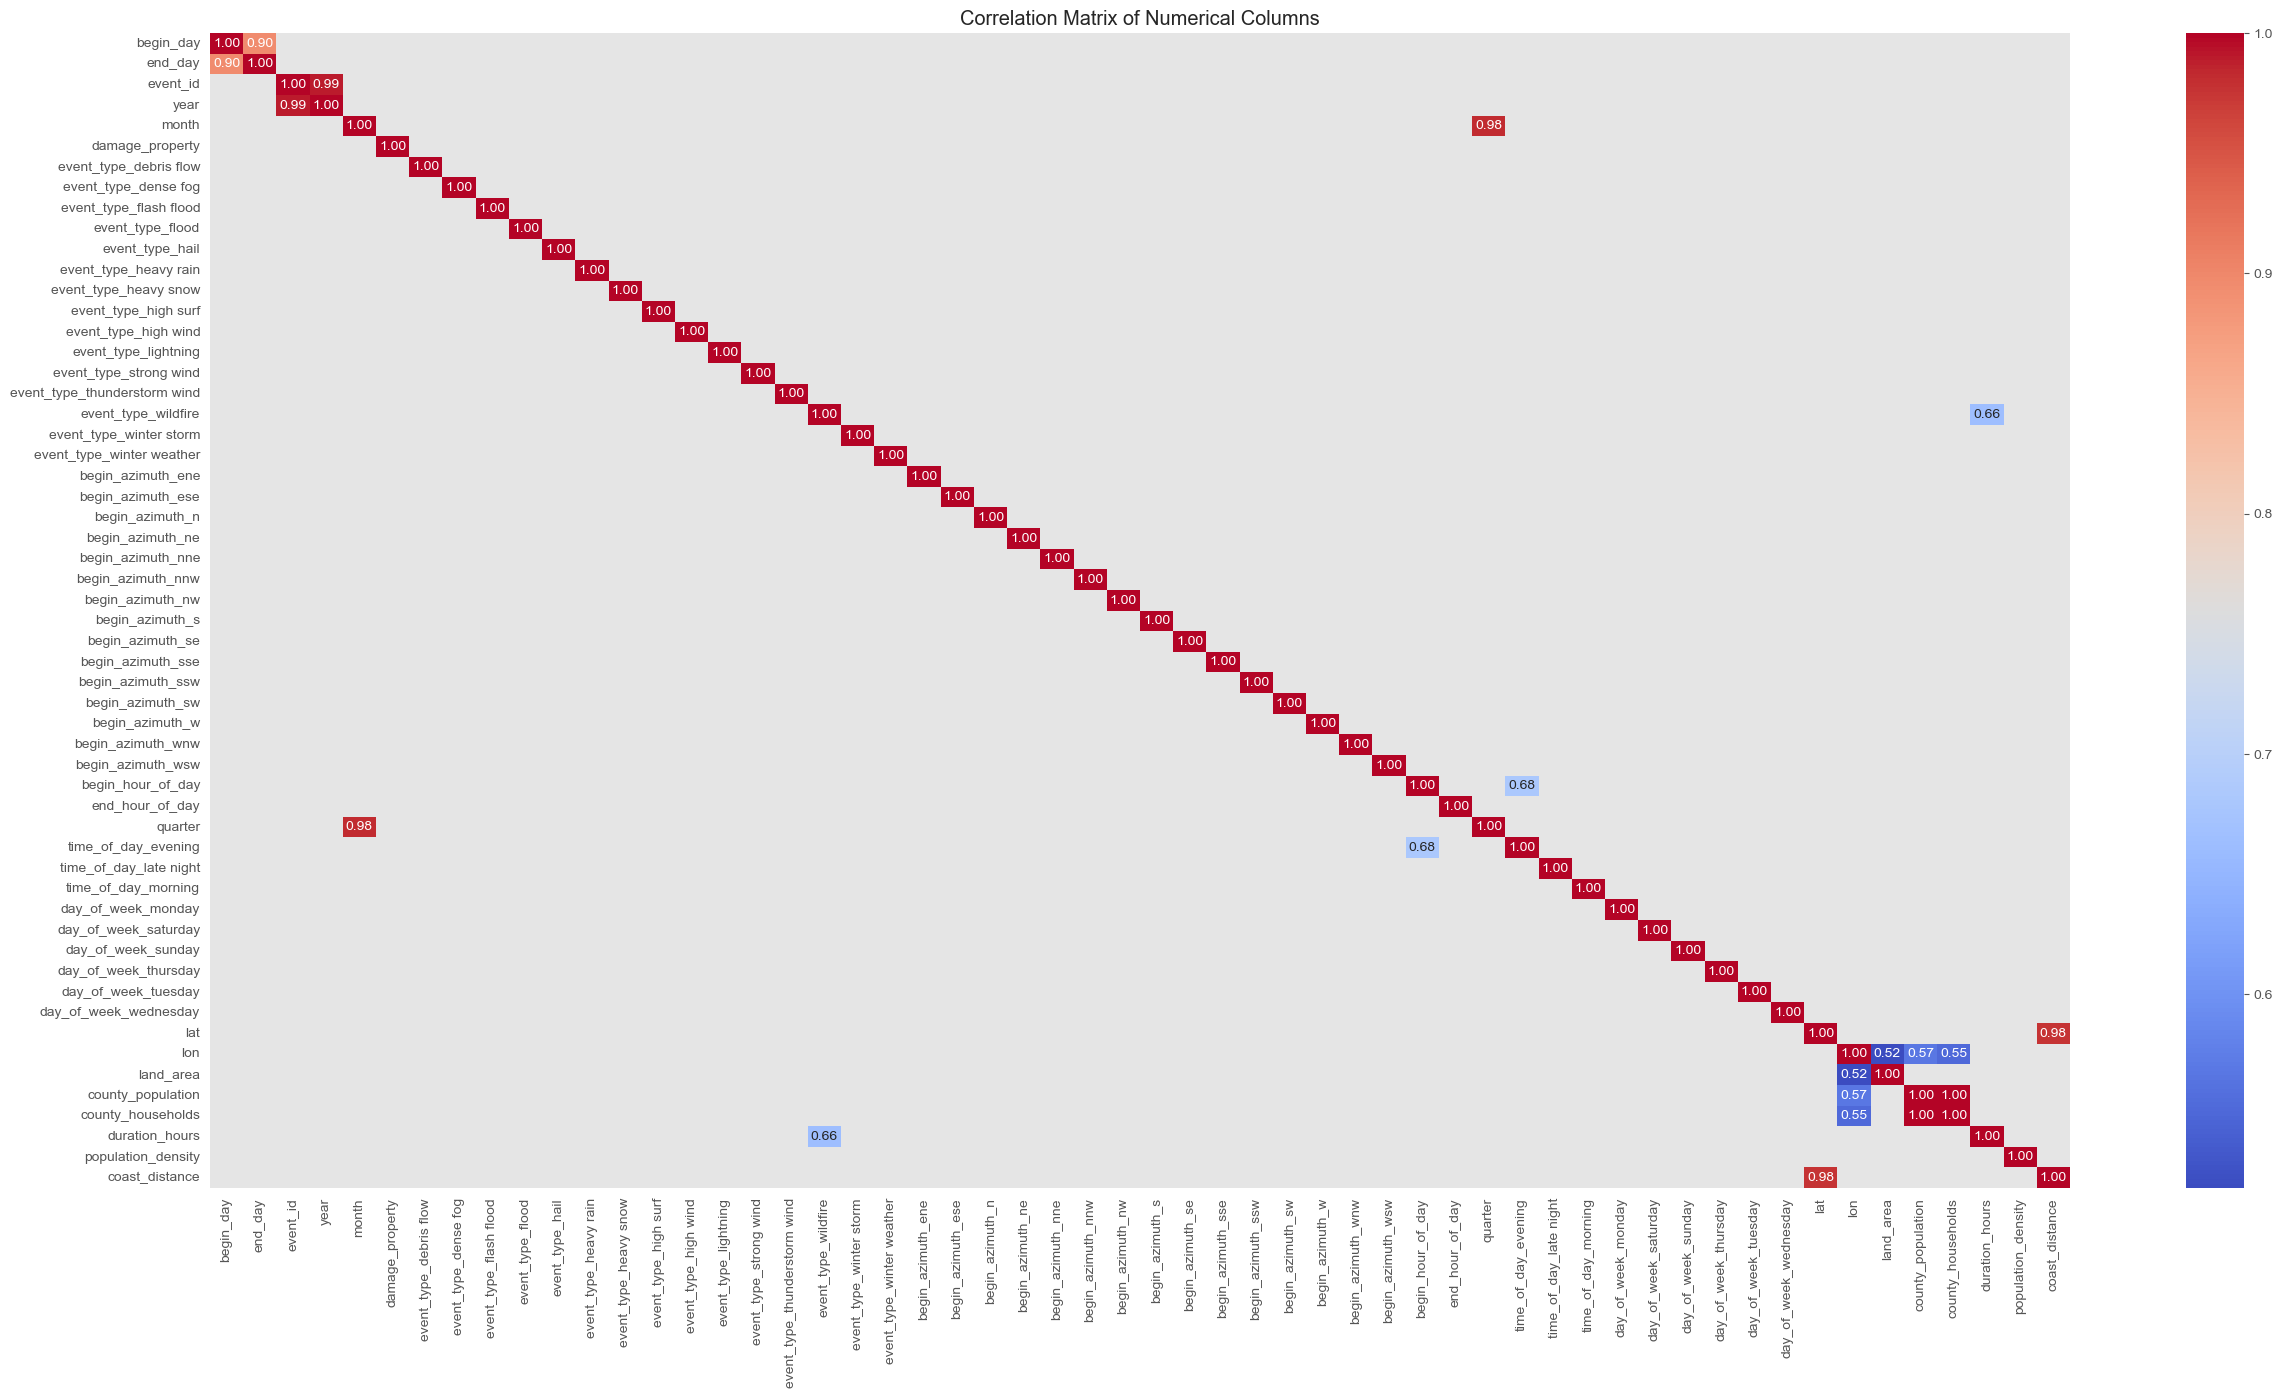

In [63]:
#correlation matrix on numerical columns that have coefficient greater than 0.5
plt.figure(figsize=(30,15))
sns.heatmap(final_storm_data.corr()[final_storm_data.corr() > 0.5], cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Matrix of Numerical Columns')
plt.show()

In [64]:
#list correlation coefficients that are 0.7 and above
correlation_matrix = final_storm_data.corr()
correlation_matrix = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
correlation_matrix = correlation_matrix.unstack().reset_index()
correlation_matrix.columns = ['Feature 1', 'Feature 2', 'Correlation']
correlation_matrix = correlation_matrix.dropna()
correlation_matrix['Correlation'] = correlation_matrix['Correlation'].abs()
correlation_matrix = correlation_matrix.sort_values(by='Correlation', ascending=False)
correlation_matrix = correlation_matrix[correlation_matrix['Correlation'] >= 0.5]
correlation_matrix

,Feature 1,Feature 2,Correlation
2963,county_households,county_population,0.998593
170,year,event_id,0.989600
2132,quarter,month,0.981948
3128,coast_distance,lat,0.976968
56,end_day,begin_day,0.895592
2792,lon,lat,0.804680
3129,coast_distance,lon,0.752320
2276,time_of_day_late night,begin_hour_of_day,0.747763
2904,county_population,lat,0.718543
2960,county_households,lat,0.703691


In [65]:
#drop columns that are highly correlated
final_storm_data = final_storm_data.drop(['quarter', 'event_id', 'county_population', 'end_day', 'time_of_day_late night', 
                                          'lat', 'lon', 'year', 'cz_type', 'county_name'], axis=1)

In [66]:
final_storm_data.shape

(11584, 49)

In [67]:
#save final dataset
final_storm_data.to_csv('final_storm_data.csv', index=False)

### Performance Criteria for Models <a class="anchor" id="performance"></a>

Since we are predicitng a continuous column, we will be utilizing performance measures that are specific only to regression problems.
* R-Squared or Coefficient of Determination (R2), a statistical measure in a regression model that determines the proportion of variance in the dependent variable that can be explained by the independent variables.
* Mean Absolute Error (MAE), which measures the average absolute difference between the predicted values and the actual target values. Useful to understand magnitude of errors.
* Root Mean Squared Error (RMSE), measures the average difference between values predicted by a model and the actual values. It provides an estimation of how well the model is able to predict the target value.

### Model Selection <a class="anchor" id="model_select"></a>

#### Possible Model Choices and Justification

When it comes to regression, we have MANY choices to choose from, including:
* Random Forest Regression
    * Justification: Handles complex datasets with mixed data types well, robust against overfitting, and doesn't require input feature scaling. Good at capturing non-linear interactions between variables without needing detailed parameter tuning.
    * Ideal Use: When you have a large and diverse dataset with a mixture of numerical and categorical variables.
* Gradient Boost Regression
    * Justification: Highly effective at reducing bias and variance through ensemble methods. It incrementally builds an ensemble of weak models, typically decision trees, to produce a powerful aggregate model. It’s particularly useful for regression problems with non-linear data distributions.
    * Ideal Use: When model accuracy is paramount and the dataset has complex patterns that simpler models can't handle.
* K-Nearest Neighbors Regression
    * Justification: Non-parametric method that works well for regression by averaging the outcomes of the nearest neighbors. It’s simple and effective, especially if the damage patterns are locally uniform.
    * Ideal Use: When data exhibits clear, localized patterns such that similar input features correlate strongly with similar outputs.
* Support Vector Regression
    * Justification: Effective in high-dimensional spaces, even in cases where the number of dimensions exceeds the number of samples. It uses kernel functions to handle non-linear relationships subtly and effectively.
    * Ideal Use: When dealing with datasets where features might exhibit complex relationships to the target variable but the data size is moderate.
* Artificial Neural Network Regression
    * Justification: Can model extremely complex patterns in data, potentially more effective for capturing intricate relationships in high-dimensional spaces. Neural networks can adapt to non-linear relationships thanks to their deep learning capabilities.
    * Ideal Use: When you have a large amount of data and computational resources, and non-linearities are expected to play a significant role.
* XGBoost
    * Justification: An optimized distributed gradient boosting library that is efficient, flexible, and portable. It performs well in a variety of predictive modeling tasks and is highly scalable.
    * Ideal Use: When performance and speed are critical, especially in large datasets.
* Ridge Regression and Lasso Regression
    * Justification: Provides a straightforward baseline model. Regularization helps prevent overfitting which can be crucial in a model with many predictors. Lasso regression can also do feature selection by shrinking coefficients for less important features to zero.
    * Ideal Use: When looking for a simple, interpretable model or as a baseline to compare more complex models against.

#### Three Model Selection

Based on the size of the dataset, especially the number of columns, the complexity of the dataset and how there are many non-linear relationships in the dataset, we decided to build three models using:
* Random Forest Regression
* Gradient Boost Regression
* XGBoost Regression

### Model Assumption Validation <a class="anchor" id="model_valid"></a>

Random Forest Regression:
- Random Forest can model the non-linear interactions between variables effectively. Storm-related data often involve complex relationships where interactions between variables (such as wind speed, precipitation, and geographic factors) significantly impact outcomes like property damage. Random Forest can handle large data sets with higher dimensionality. It can manage thousands of input variables without variable deletion, making it a robust choice for complex datasets that include various types of data (e.g., numerical, categorical). This is ideal since we will be working almost sixty independent variables and many of the numerical columns within the dataset have non-linear relationships.

Gradient Boosting Regression:
- Gradient Boosting can model complex non-linear relationships, making it suitable for datasets with diverse types of variables and interactions. The dataset contains features like time, geographic coordinates, and various weather event types that may interact in complex ways. Gradient Boosting is generally robust to outliers, which is beneficial given the variability in weather-related datasets and the number of extreme values in the damage_property column.

XGBoost Regression:
- The algorithm includes built-in regularization—both L1 (Lasso regression) and L2 (Ridge regression)—which helps prevent overfitting. This is particularly important in regression tasks where the goal is to generalize well to unseen data, such as predicting future storm damage.

- The nature of gradient boosting allows XGBoost to model complex interactions between variables effectively. This feature is crucial when dealing with the multifaceted nature of storm damage, where factors like storm intensity, geography, and built environment characteristics interact in complex ways.

### Creating Training and Testing Sets <a class="anchor" id="create_train"></a>

In [68]:
final_storm_data = pd.read_csv('/Users/luisotero/Library/CloudStorage/OneDrive-lmu.edu/Documents/BSAN6070/final_storm_data.csv')

In [69]:
final_storm_data.columns

Index(['begin_day', 'month', 'damage_property', 'event_type_debris flow',
       'event_type_dense fog', 'event_type_flash flood', 'event_type_flood',
       'event_type_hail', 'event_type_heavy rain', 'event_type_heavy snow',
       'event_type_high surf', 'event_type_high wind', 'event_type_lightning',
       'event_type_strong wind', 'event_type_thunderstorm wind',
       'event_type_wildfire', 'event_type_winter storm',
       'event_type_winter weather', 'begin_azimuth_ene', 'begin_azimuth_ese',
       'begin_azimuth_n', 'begin_azimuth_ne', 'begin_azimuth_nne',
       'begin_azimuth_nnw', 'begin_azimuth_nw', 'begin_azimuth_s',
       'begin_azimuth_se', 'begin_azimuth_sse', 'begin_azimuth_ssw',
       'begin_azimuth_sw', 'begin_azimuth_w', 'begin_azimuth_wnw',
       'begin_azimuth_wsw', 'begin_hour_of_day', 'end_hour_of_day',
       'time_of_day_evening', 'time_of_day_morning', 'day_of_week_monday',
       'day_of_week_saturday', 'day_of_week_sunday', 'day_of_week_thursday',
    

In [70]:
#create train and test sets
X = final_storm_data.drop('damage_property', axis=1)
Y = final_storm_data['damage_property']

#using train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 1917, train_size=0.7, shuffle = True)

#print out train and test sets
print("X_train shape:", x_train.shape)
print("X_test shape:", x_test.shape)
print("––––––––––––––––––––––––––––––––––––––––––––––––––")
print("Y_train shape:", y_train.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (8108, 48)
X_test shape: (3476, 48)
––––––––––––––––––––––––––––––––––––––––––––––––––
Y_train shape: (8108,)
Y_test shape: (3476,)


### Model 1: Random Forest Regression <a class="anchor" id="model1"></a>

#### Build First Version of Model

In [71]:
#build first version of model
rf = RandomForestRegressor(n_estimators = 300, criterion = 'squared_error', random_state = 1917, max_depth = None,
                           min_samples_split = 2, min_samples_leaf = 1, max_features = None)

#fit (train) the model
rf.fit(x_train, y_train)

#test the model (make predictions)
y_pred = rf.predict(x_test)

#### Evaluate Performance of First Version Model

In [72]:
#calculate metrics on test set
r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

#print metrics
print("RF Test Set Metrics")
print("R2:", r2)
print("RMSE:", rmse)
print("MAE:", mae)

RF Test Set Metrics
R2: 0.2774694562967548
RMSE: 859529.2934191816
MAE: 90725.66694859994


#### Feature Engineering and Selection

##### Dimensionality Reduction

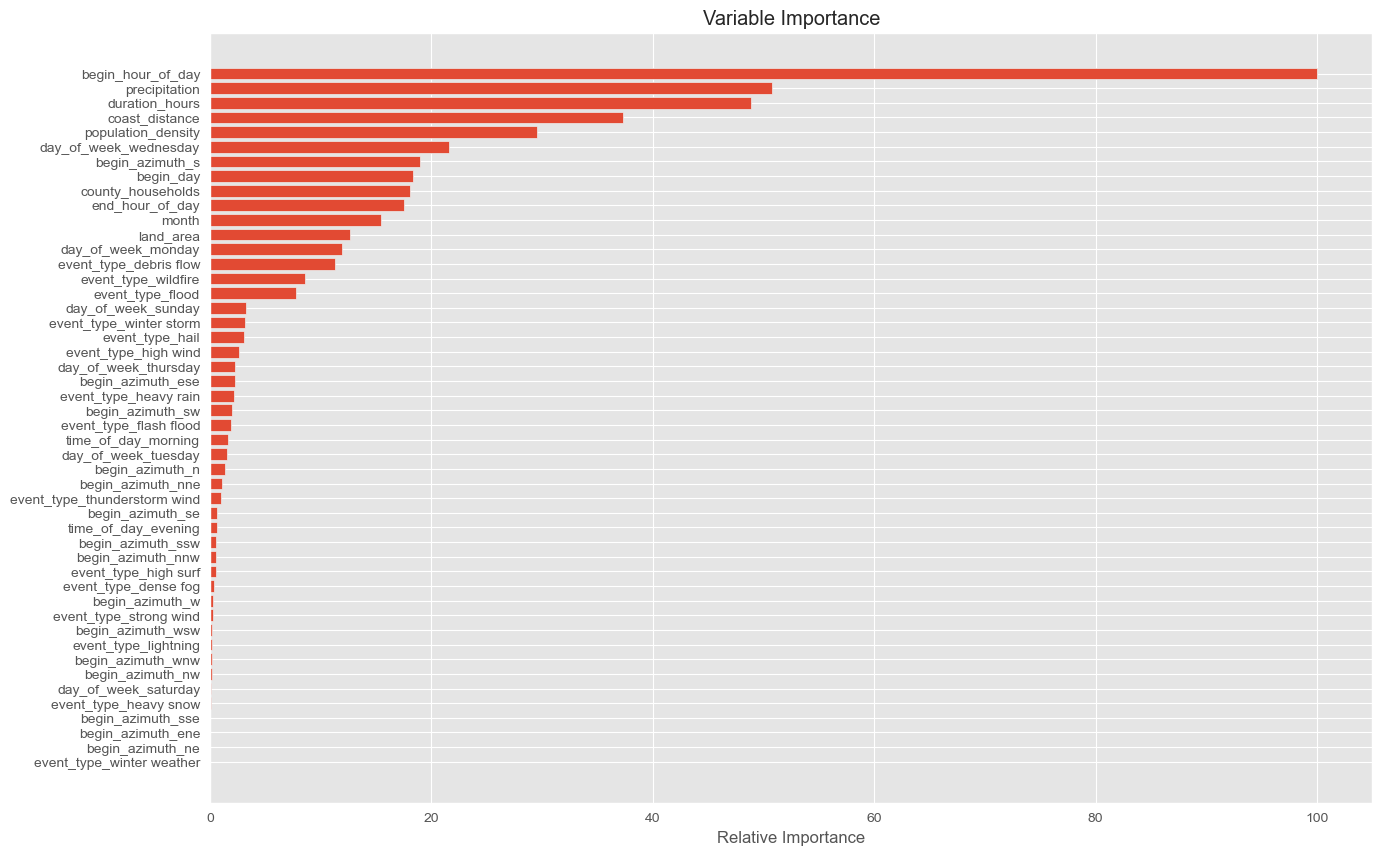

In [73]:
#using built in feature importance on random forest
feature_importance = rf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(15, 10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, x_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [74]:
#store feature importance in a dataframe
feature_importance_df = pd.DataFrame(feature_importance, index = x_train.columns, columns = ['Importance'])
feature_importance_df = feature_importance_df.sort_values(by = 'Importance', ascending = False)

#display top 20 features
feature_importance_df.head(20)

,Importance
begin_hour_of_day,100.000000
precipitation,50.765618
duration_hours,48.884413
coast_distance,37.339764
population_density,29.539684
day_of_week_wednesday,21.592349
begin_azimuth_s,18.994828
begin_day,18.294751
county_households,18.106864
end_hour_of_day,17.531222


In [75]:
#build second version of Random Forest using top 20 features
top_features = feature_importance_df.head(20).index
x_train_top = x_train[top_features]
x_test_top = x_test[top_features]

#build second version of model
rf_top = RandomForestRegressor(n_estimators = 300, criterion = 'squared_error', random_state = 1917, max_depth = None,
                           min_samples_split = 2, min_samples_leaf = 1, min_weight_fraction_leaf = 0.0, max_features = None)

#fit (train) the model
rf_top.fit(x_train_top, y_train)

#test the model (make predictions)
y_pred_top = rf_top.predict(x_test_top)

#calculate metrics
r2_top = r2_score(y_test, y_pred_top)
mse_top = root_mean_squared_error(y_test, y_pred_top)
rmse_top = np.sqrt(mse_top)
mae_top = mean_absolute_error(y_test, y_pred_top)

#display metrics
print("Random Forest Regression Model Metrics with Top 20 Features")
print("R2:", r2_top)
print("RMSE:", rmse_top)
print("MAE:", mae_top)

Random Forest Regression Model Metrics with Top 20 Features
R2: 0.2727881217713618
RMSE: 928.6060941383187
MAE: 97636.15570387417


##### Rationale

Built-in Feature Importance: Each tree of the random forest can calculate the importance of a feature according to its ability to increase the pureness of the leaves. Random forest algorithms provide built-in methods to evaluate feature importance based on how much each feature decreases the impurity of the splits it is involved in (variance reduction for regression). This is the most straightforward and commonly used method for feature selection in random forests because it directly measures the impact of each feature within the context of the model.

We tried using Recursive Feature Elimination Cross Validation (RFECV), which iteratively builds models and removes the least important feature at each step, but it turned out to be too computationally intensive. The process kept running for over an hour withouyt producing a result so we decided to go with the built-in feature importance.

#### Optimizing Model with Hyperparameter Tuning

##### Random Search and Grid Search CV

In [76]:
#number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

#number of features to consider at every split
max_features = ['auto', 'log2']

#maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

#minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

#minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

#method of selecting samples for training each tree
bootstrap = [True, False]

#create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [77]:
#random search of parameters, using 3 fold cross validation
rf_random = RandomizedSearchCV(estimator = rf_top, param_distributions = random_grid, n_iter = 100, cv = 3, 
                               verbose=2, random_state=1971, n_jobs = -1)

#fit the random search model
rf_random.fit(x_train_top, y_train);

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   0.0s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estima

/Users/luisotero/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning:


171 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
79 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/luisotero/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/luisotero/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/luisotero/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_paramet

In [78]:
#view best parameters
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 90,
 'bootstrap': False}

In [79]:
#test the model (make predictions)
y_pred_random = rf_random.predict(x_test_top)

#calculate metrics
r2_random = r2_score(y_test, y_pred_random)
rmse_random = root_mean_squared_error(y_test, y_pred_random)
mae_random = mean_absolute_error(y_test, y_pred_random)

#display metrics
print("RF Random Model Performance Measures")
print("R2:", r2_random)
print("RMSE:", rmse_random)
print("MAE:", mae_random)

RF Random Model Performance Measures
R2: 0.327520212566464
RMSE: 829224.632693174
MAE: 89555.75274520523


In [80]:
#create parameter grid based on results of random search
param_grid2 = {
    'bootstrap': [False],
    'max_depth': [80, 90, 100, 110],
    'max_features': ['log2'],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 4, 6],
    'n_estimators': [1000]
}

#instantiate grid search model
grid_search = GridSearchCV(estimator = rf_top, param_grid = param_grid2, 
                          cv = 5, n_jobs = -1, verbose = 2)

#fit the grid search to the data
grid_search.fit(x_train_top, y_train);

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END bootstrap=False, max_depth=80, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  10.7s
[CV] END bootstrap=False, max_depth=80, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  11.0s
[CV] END bootstrap=False, max_depth=80, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1000; total time=  10.8s
[CV] END bootstrap=False, max_depth=80, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1000; total time=  10.5s
[CV] END bootstrap=False, max_depth=80, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  11.2s
[CV] END bootstrap=False, max_depth=80, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  11.1s
[CV] END bootstrap=False, max_depth=80, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimato

In [81]:
#view best parameters
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 80,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [82]:
#test the model (make predictions)
y_pred_grid = grid_search.predict(x_test_top)

#calculate metrics
r2_grid = r2_score(y_test, y_pred_grid)
rmse_grid = root_mean_squared_error(y_test, y_pred_grid)
mae_grid = mean_absolute_error(y_test, y_pred_grid)

#display metrics
print("RF Grid Search Performance Measures")
print("R2:", r2_grid)
print("RMSE:", rmse_grid)
print("MAE:", mae_grid)

RF Grid Search Performance Measures
R2: 0.327520212566464
RMSE: 829224.632693174
MAE: 89555.75274520523


##### Justification

If we had used just K-Fold Cross Validation, we would have had to perform many iterations of the K-Fold CV process in hyperparameter tuning using different model settings each time. Each time we want to assess a different set of hyperparameters, we have to split our training data into K fold and train and evaluate however many times we specify K.

Using Scikit-Learn’s RandomizedSearchCV method, we can define a grid of hyperparameter ranges, and randomly sample from the grid, performing K-Fold CV with each combination of values. We can view the best parameters from fitting the random search.

Random search allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try. Using Grid Search cross validation, we can find the optimal parameter values from a given set of parameters in a grid. We define a grid where we explicitly specify every combination of hyperparameters to try, and the method evaluates all the combinations we define. 

#### Build Best Model

In [83]:
best_param = {'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 80,
 'bootstrap': False}

#build third version of Random Forest using top 20 features
rf_best = RandomForestRegressor(n_estimators = best_param['n_estimators'], criterion = 'squared_error', random_state = 1917, max_depth = best_param['max_depth'],
                           min_samples_split = best_param['min_samples_split'], min_samples_leaf = best_param['min_samples_leaf'], max_features = best_param['max_features'],
                           bootstrap = best_param['bootstrap'])

#fit (train) the model
rf_best.fit(x_train_top, y_train)

#test the model (make predictions)
y_pred_best = rf_best.predict(x_test_top)

#calculate metrics
r2_top_grid = r2_score(y_test, y_pred_best)
rmse_top_grid = root_mean_squared_error(y_test, y_pred_best)
mae_top_grid = mean_absolute_error(y_test, y_pred_best)

#display metrics
print("Random Forest Regression Model Metrics with Top 20 Features and Grid Search Hyperparameters")
print("R2:", r2_top_grid)
print("RMSE:", rmse_top_grid)
print("MAE:", mae_top_grid)

Random Forest Regression Model Metrics with Top 20 Features and Grid Search Hyperparameters
R2: 0.327520212566464
RMSE: 829224.632693174
MAE: 89555.75274520523


### Model 2: Gradient Boosting Regression <a class="anchor" id="model2"></a>

#### Build First Version of Model

In [84]:
#initialize gradient boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=1971)

#fit the model
gb_model.fit(x_train, y_train)

GradientBoostingRegressor(random_state=1971)

#### Evaluate Performance of First Version Model

In [85]:
#test the model (make predictions)
y_pred_gb = gb_model.predict(x_test)

#calculate metrics
r2_gb = r2_score(y_test, y_pred_gb)
rmse_gb = root_mean_squared_error(y_test, y_pred_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)

#display metrics
print("RF Random Model Performance Measures")
print("R2:", r2_gb)
print("RMSE:", rmse_gb)
print("MAE:", mae_gb)

RF Random Model Performance Measures
R2: 0.3746730332876941
RMSE: 799624.617128521
MAE: 108625.03407600618


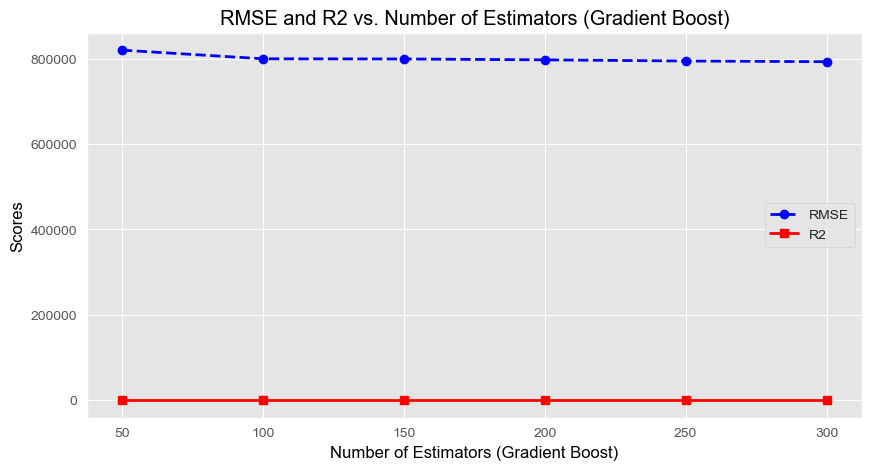

In [86]:
#initialize lists to store RMSE and R2 scores
rmse_results = []
r2_results = []

estimators = [50, 100, 150, 200, 250, 300]  #example list of estimators

for n in estimators:
    #create GradientBoostingRegressor with n estimators
    model = GradientBoostingRegressor(n_estimators=n, random_state=1971)
    
    # Fit the model on the training set
    model.fit(x_train, y_train)
    
    # Predict the target variable on the test set
    y_pred = model.predict(x_test)
    
    # Calculate RMSE and R2 and add scores to lists
    rmse_results.append(root_mean_squared_error(y_test, y_pred))
    r2_results.append(r2_score(y_test, y_pred))

#plot the RMSE scores
plt.figure(figsize=(10,5))
plt.plot(estimators, rmse_results, color='blue', marker='o', linestyle='--', linewidth=2, label='RMSE')
plt.plot(estimators, r2_results, color='red', marker='s', linestyle='-', linewidth=2, label='R2')
plt.title('RMSE and R2 vs. Number of Estimators (Gradient Boost)', color='black')
plt.xlabel('Number of Estimators (Gradient Boost)', color='black')
plt.ylabel('Scores', color='black')
plt.legend()
plt.grid(True)
plt.show()

In [87]:
#store max R2 and min rmse scores
print("Min RMSE:", min(rmse_results), "Max R2:", max(r2_results))

#store results in a dataframe
results = [rmse_results, r2_results]

#print results
gr_results = pd.DataFrame(results, columns = estimators, index = ['RMSE', 'R2'])
gr_results

Min RMSE: 792780.1381991452 Max R2: 0.38533233371608144


,50,100,150,200,250,300
RMSE,819857.593736,799624.617129,799224.074152,797088.969228,794430.265761,792780.138199
R2,0.342627,0.374673,0.375299,0.378633,0.382771,0.385332


#### Feature Engineering and Selection

##### Dimensionality Reduction

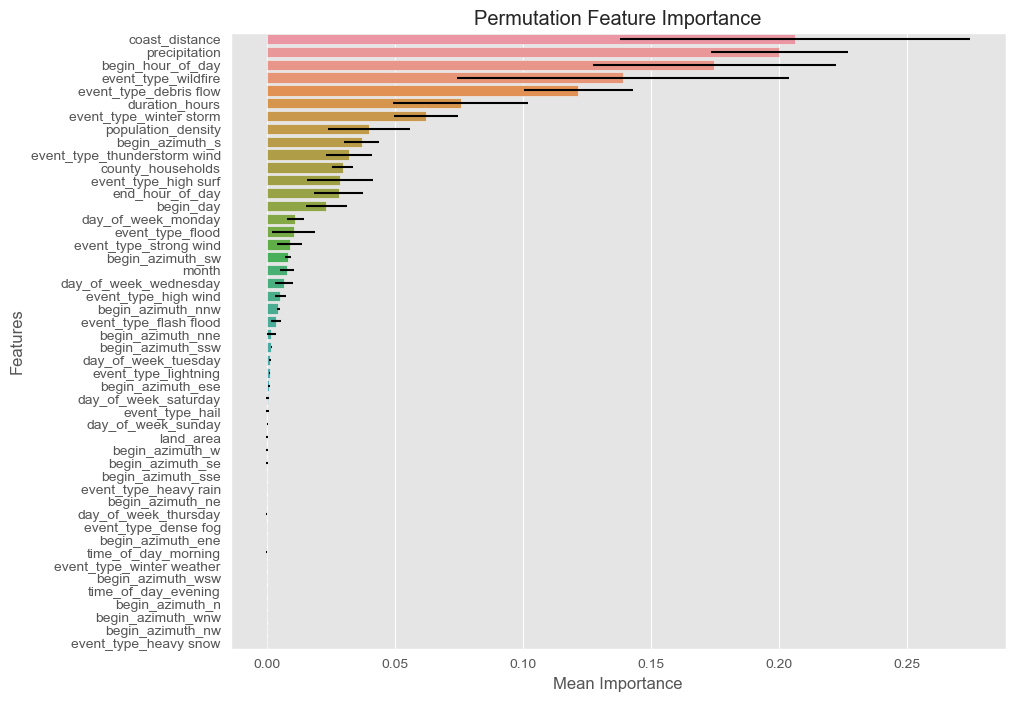

In [88]:
#assuming 'model' is your trained model, and X_test, y_test are your testing data
result = permutation_importance(model, x_test, y_test, n_repeats=30, random_state=1971)

#organize the results into a DataFrame
perm_importance_df = pd.DataFrame({'features': x_test.columns, 
                                   'importance_mean': result.importances_mean, 
                                   'importance_std': result.importances_std})

#sort the DataFrame by importance_mean in descending order
perm_importance_df = perm_importance_df.sort_values(by="importance_mean", ascending=False)

#plotting the results with seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x="importance_mean", y="features", data=perm_importance_df, 
            xerr=perm_importance_df['importance_std'])
plt.title('Permutation Feature Importance')
plt.xlabel('Mean Importance')
plt.ylabel('Features')
plt.show()

In [89]:
#organize the results into a DataFrame
perm_importance_df = pd.DataFrame({
    'features': x_test.columns,
    'importance_mean': result.importances_mean
})

#sort the DataFrame by importance_mean in descending order and get the top 20
top_20_features = perm_importance_df.sort_values(by='importance_mean', ascending=False).head(20)

#display the top 20 features
print(top_20_features)

                        features  importance_mean
47                coast_distance         0.206359
44                 precipitation         0.200032
32             begin_hour_of_day         0.174722
14           event_type_wildfire         0.139153
2         event_type_debris flow         0.121684
45                duration_hours         0.075700
15       event_type_winter storm         0.062135
46            population_density         0.039927
24               begin_azimuth_s         0.037093
13  event_type_thunderstorm wind         0.032232
43             county_households         0.029704
9           event_type_high surf         0.028640
33               end_hour_of_day         0.028207
0                      begin_day         0.023288
36            day_of_week_monday         0.011177
5               event_type_flood         0.010520
12        event_type_strong wind         0.008955
28              begin_azimuth_sw         0.008321
1                          month         0.007808


##### Rationale

For feature selection, we chose to use permutation feature importance to understand influential features. This is an efficient way to figure out the top contributors to property_damage as it calculates the decrease in model accuracy and selects the top twenty features. It is also good to as it reduces overfitting, since it can be calculated multiple times with different permutations of the feature, further providing a measure of the variance in the estimated feature importances for the specific trained model.

#### Optimizing Model with Hyperparameter Tuning

##### Finding Best Number of Estimators and K-Fold Cross Validation

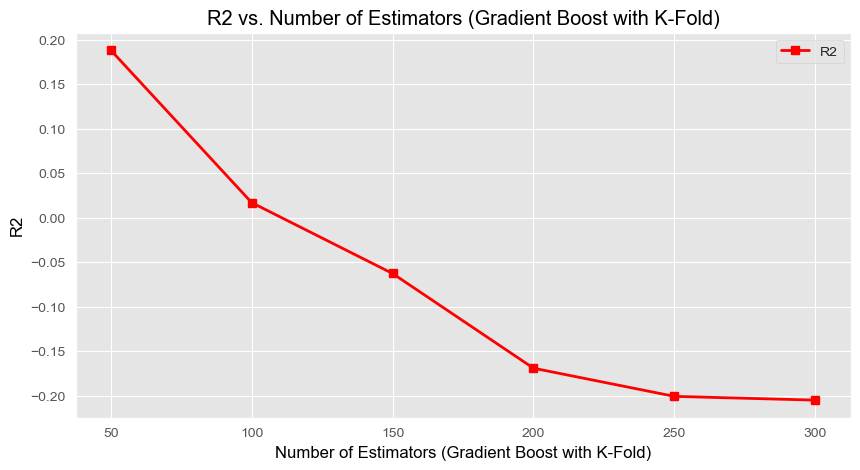

In [90]:
#list of top features names excluding 'episode_id' and 'event_id'
top_features_names = ['coast_distance', 'precipitation', 'begin_hour_of_day', 'event_type_wildfire', 'event_type_debris flow', 'duration_hours',
                      'event_type_winter storm', 'population_density', 'begin_azimuth_s', 'event_type_thunderstorm wind', 'county_households',
                      'event_type_high surf', 'end_hour_of_day', 'begin_day', 'day_of_week_monday', 'event_type_flood', 'event_type_strong wind',
                      'begin_azimuth_sw', 'month', 'day_of_week_wednesday']

#assuming 'X' is your full features DataFrame and 'y' is the target series
X_top = X[top_features_names]

#split the data with the selected top features
X_train_top, X_test_top, Y_train_top, Y_test_top = train_test_split(X_top, Y, test_size=0.3, random_state=1971, shuffle = True)

#initialize lists to store RMSE and R2 scores
k_rmse_results = []
k_r2_results = []

#define your range of estimators
estimators = [50, 100, 150, 200, 250, 300]

#define scoring for K-Fold
metrics = ['neg_root_mean_squared_error', 'r2']

#loop through the defined range of estimators
for n in estimators:
    
    #create GradientBoostingRegressor with n estimators
    model = GradientBoostingRegressor(n_estimators=n, random_state=1971)
    
    #test the model using K-Fold cross validation
    cv_results = cross_validate(model, X_train_top, Y_train_top, cv=5, scoring=metrics)

    #calculate RMSE and R2 and add scores to lists
    k_rmse_results.append(-cv_results['test_neg_root_mean_squared_error'].mean())
    k_r2_results.append(cv_results['test_r2'].mean())

#plot R2 scores
plt.figure(figsize=(10,5))
plt.plot(estimators, k_r2_results, color='red', marker='s', linestyle='-', linewidth=2, label='R2')
plt.title('R2 vs. Number of Estimators (Gradient Boost with K-Fold)', color='black')
plt.xlabel('Number of Estimators (Gradient Boost with K-Fold)', color='black')
plt.ylabel('R2', color='black')
plt.legend()
plt.grid(True)
plt.show()

In [91]:
#store max r2 and min rmse scores
print("Min RMSE:", min(k_rmse_results), "Max R2:", max(k_r2_results))

#store results in a DataFrame
k_results = pd.DataFrame([k_rmse_results, k_r2_results], columns = estimators, index = ['RMSE', 'R2'])

#display results
k_results

Min RMSE: 776060.667652244 Max R2: 0.18836513918586434


,50,100,150,200,250,300
RMSE,776060.667652,808601.147745,825236.433982,850617.942622,860085.595415,862248.410454
R2,0.188365,0.016920,-0.062796,-0.169296,-0.200961,-0.205210


##### Finding Best Learning Rate

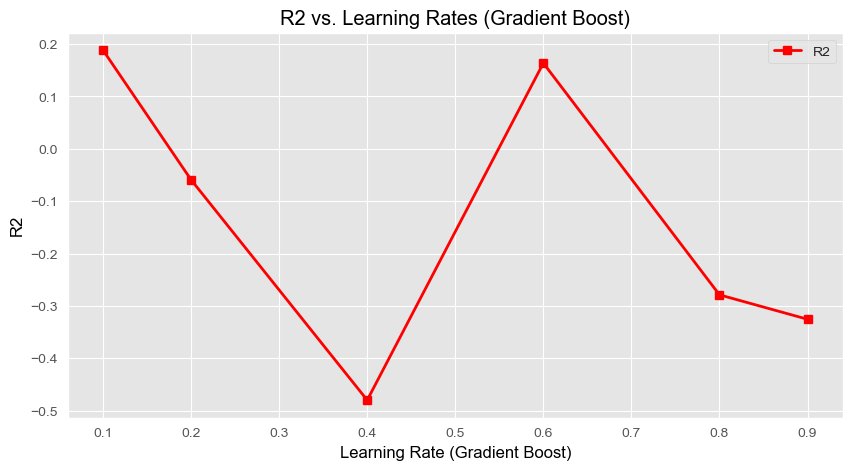

In [92]:
#initialize lists to store RMSE and R2 scores
k_rmse_results = []
k_r2_results = []

#define your range of learning_rates
learning_rates = [0.1, 0.2, 0.4, 0.6, 0.8, 0.9]

#loop through the defined range of learning_rates
for n in learning_rates:
    
    #create GradientBoostingRegressor with n learning_rates
    model = GradientBoostingRegressor(n_estimators = 50, learning_rate=n, random_state=1971)

    #test the model using K-Fold cross validation
    cv_results = cross_validate(model, X_train_top, Y_train_top, cv=5, scoring=metrics)

    #calculate RMSE and R2 and add scores to lists
    k_rmse_results.append(-cv_results['test_neg_root_mean_squared_error'].mean())
    k_r2_results.append(cv_results['test_r2'].mean())

#plot R2 scores
plt.figure(figsize=(10,5))
plt.plot(learning_rates, k_r2_results, color='red', marker='s', linestyle='-', linewidth=2, label='R2')
plt.title('R2 vs. Learning Rates (Gradient Boost)', color='black')
plt.xlabel('Learning Rate (Gradient Boost)', color='black')
plt.ylabel('R2', color='black')
plt.legend()
plt.grid(True)
plt.show()

In [93]:
#store max R2 and min rmse scores
print("Min RMSE:", min(k_rmse_results), "Max R2:", max(k_r2_results))

#store results in a dataframe
results = [k_rmse_results, k_r2_results]

#print results
gr_results = pd.DataFrame(results, columns = learning_rates, index = ['RMSE', 'R2'])
gr_results

Min RMSE: 776060.667652244 Max R2: 0.18836513918586434


,0.1,0.2,0.4,0.6,0.8,0.9
RMSE,776060.667652,822014.093765,880047.967627,776533.897045,877132.268665,933904.505091
R2,0.188365,-0.059230,-0.480041,0.163627,-0.278932,-0.325600


##### Finding Best Max Depth

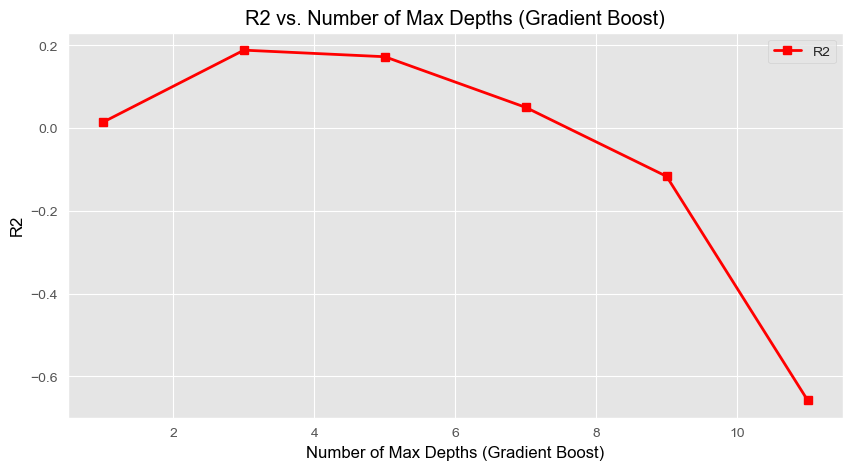

In [94]:
#initialize lists to store RMSE and R2 scores
k_rmse_results = []
k_r2_results = []

#define your range of max_depths
max_depths = [None, 1, 3, 5, 7, 9, 11]

#loop through the defined range of max_depths
for n in max_depths:
    
    #create GradientBoostingRegressor with n max_depths
    model = GradientBoostingRegressor(n_estimators = 50, learning_rate = 0.1, max_depth = n,random_state=1971)

    #test the model using K-Fold cross validation
    cv_results = cross_validate(model, X_train_top, Y_train_top, cv=5, scoring=metrics)

    #calculate RMSE, MAE, and R2 and add scores to lists
    k_rmse_results.append(-cv_results['test_neg_root_mean_squared_error'].mean())
    k_r2_results.append(cv_results['test_r2'].mean())

#plot R2 scores
plt.figure(figsize=(10,5))
plt.plot(max_depths, k_r2_results, color='red', marker='s', linestyle='-', linewidth=2, label='R2')
plt.title('R2 vs. Number of Max Depths (Gradient Boost)', color='black')
plt.xlabel('Number of Max Depths (Gradient Boost)', color='black')
plt.ylabel('R2', color='black')
plt.legend()
plt.grid(True)
plt.show()

In [95]:
#store max accuracy and auc scores
max_gr = [min(k_rmse_results), max(k_r2_results)]
print("Min RMSE:", min(k_rmse_results), "Max R2:", max(k_r2_results))

#store results in a dataframe
results = [k_rmse_results, k_r2_results]

#print results
gr_results = pd.DataFrame(results, columns = max_depths, index = ['RMSE', 'R2'])
gr_results

Min RMSE: 776060.667652244 Max R2: 0.18836513918586434


,NaN,1.0,3.0,5.0,7.0,9.0,11.0
RMSE,932419.258966,886626.824562,776060.667652,778717.376097,793628.081688,839471.969492,931912.562507
R2,-0.593861,0.014280,0.188365,0.172451,0.050002,-0.116769,-0.657495


##### Justification

To find the most optimal values for each hyperparameter, we looped through a list of values for each hyperparameter, fitted a Gradient Boosting Regressor for each value in that list, and measured the performance of the model with K-Fold Cross Validation. Whichever value presented the highest mean R2 and lowest mean squared error, that would be the value we proceed with. This also ensures that we are choosing the most optimal value for each hyperparameter so our model is not overfitting or underfitting.

#### Build Best Model

In [96]:
#final parameters
best_param = {'n_estimators': 50, 'learning_rate': 0.1, 'max_depth': 3}

#build final model
gb_best = GradientBoostingRegressor(n_estimators = best_param['n_estimators'], learning_rate = best_param['learning_rate'], 
                                    max_depth = best_param['max_depth'], random_state = 1971)

#fit (train) the model
gb_best.fit(X_train_top, Y_train_top)

#test the model (make predictions)
y_pred_best = gb_best.predict(X_test_top)

#calculate metrics
r2_best = r2_score(Y_test_top, y_pred_best)
rmse_best = root_mean_squared_error(Y_test_top, y_pred_best)
mae_best = mean_absolute_error(Y_test_top, y_pred_best)

#display metrics
print("Gradient Boosting Regression Model Metrics with Top 20 Features and K-Fold Hyperparameters")
print("R2:", r2_best)
print("RMSE:", rmse_best)
print("MAE:", mae_best)

Gradient Boosting Regression Model Metrics with Top 20 Features and K-Fold Hyperparameters
R2: 0.3490669880246563
RMSE: 711131.0255511515
MAE: 122148.87113040067


### Model 3: XGBoost Regressor <a class="anchor" id="model3"></a>

#### Build First Version of Model

In [97]:
#build xgboost model
xgb_model = xg.XGBRegressor(objective = 'reg:linear', n_estimators = 100, seed = 1971)

#fitting the model
xgb_model.fit(x_train, y_train);

[18:33:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


#### Evaluate Performance of First Version Model

In [98]:
#predicting the target variable
y_pred_xgb = xgb_model.predict(x_test)

#calculate metrics
r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = root_mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

#display metrics
print("XGBoost Model Performance Measures")
print("R2:", r2_xgb)
print("RMSE:", rmse_xgb)
print("MAE:", mae_xgb)

XGBoost Model Performance Measures
R2: 0.20791597638062664
RMSE: 899949.6320982681
MAE: 88582.60300284233


#### Feature Selection and Dimensionality Reduction

##### Methodology

In [99]:
#get feature importance
feature_importance_xgb = xgb_model.feature_importances_

#store feature importance in a dataframe
feature_importance_df_xgb = pd.DataFrame(feature_importance_xgb, index = x_train.columns, columns = ['Importance'])
feature_importance_df_xgb = feature_importance_df_xgb.sort_values(by = 'Importance', ascending = False)

#display top 20 features
feature_importance_df_xgb.head(20)

,Importance
begin_azimuth_s,0.535374
begin_hour_of_day,0.077724
day_of_week_sunday,0.057076
event_type_debris flow,0.051825
coast_distance,0.025067
month,0.024141
duration_hours,0.018819
day_of_week_wednesday,0.015475
precipitation,0.014758
begin_azimuth_se,0.014743


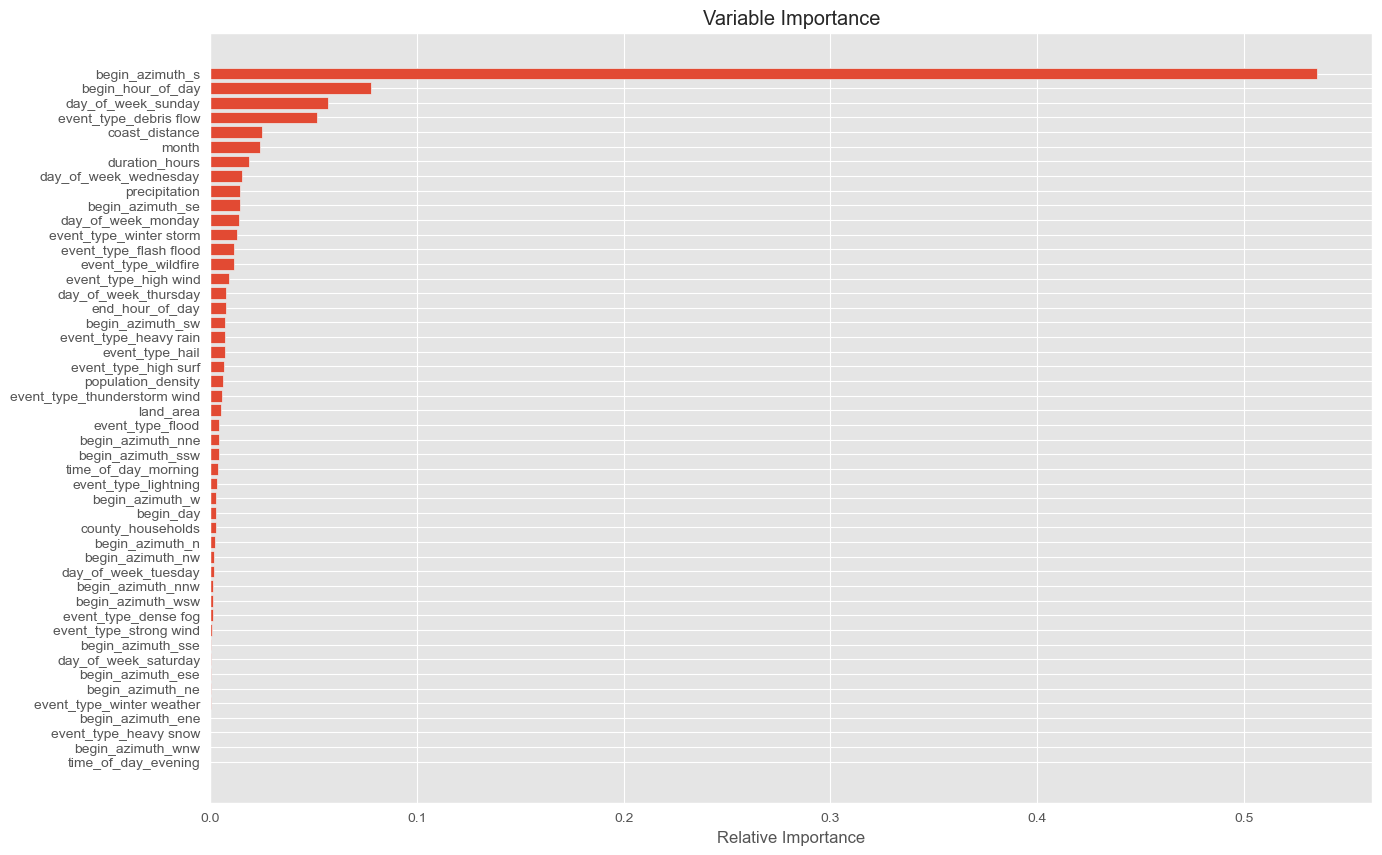

In [100]:
#using built in feature importance on XGboost
feature_importance = xgb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(15, 10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, x_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [101]:
#build second version of XGBoost using top 20 features
top_features = feature_importance_df_xgb.head(20).index
x_train_top_xgb = x_train[top_features]
x_test_top_xgb = x_test[top_features]

#build second version of model
xgb_top = xg.XGBRegressor(objective = 'reg:squarederror', n_estimators = 100, seed = 1971)

#fit (train) the model
xgb_top.fit(x_train_top_xgb, y_train)

#test the model (make predictions)
y_pred_top_xgb = xgb_top.predict(x_test_top_xgb)

#calculate metrics
r2_top_xgb = r2_score(y_test, y_pred_top_xgb)
mae_top_xgb = mean_absolute_error(y_test, y_pred_top_xgb)
rmse_top_xgb = root_mean_squared_error(y_test, y_pred_top_xgb)

#display metrics
print("XGBoost Model Performance Measures with Top 20 Features")
print("R2:", r2_top_xgb)
print("RMSE:", rmse_top_xgb)
print("MAE:", mae_top_xgb)

XGBoost Model Performance Measures with Top 20 Features
R2: 0.15930338822449785
RMSE: 927154.7454321842
MAE: 92221.92510984572


##### Rationale

XGBoost can automatically provide feature importance scores after training. These scores help identify which features are most influential in predicting the target variable. This is the most straightforward method and can be accessed directly from the model properties. It is also straightforward as I can use the importance scores to select a subset of features that contribute the most to the prediction.

#### Optimizing Model with Hyperparameter Tuning

##### Grid Search CV

In [102]:
#specify parameters and distributions to sample from
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

#instantiate the grid search model
grid_search_xgb = GridSearchCV(estimator = xgb_top, param_grid=param_grid, scoring='r2', cv=3, verbose=1)
grid_search_xgb.fit(x_train_top_xgb, y_train);

Fitting 3 folds for each of 108 candidates, totalling 324 fits


##### Justification

Grid search is one of the most traditional methods for hyperparameter tuning. It involves specifying a grid of hyperparameter values and exhaustively searching through them to find the combination that performs the best based on a cross-validation set. This method is very thorough but can be computationally expensive, especially with a large number of hyperparameters and deep grids.

#### Build Best Model

In [103]:
#test the model (make predictions)
y_pred_grid_xgb = grid_search_xgb.predict(x_test_top_xgb)

#calculate metrics
r2_grid = r2_score(y_test, y_pred_grid_xgb)
rmse_grid = root_mean_squared_error(y_test, y_pred_grid_xgb)
mae_grid = mean_absolute_error(y_test, y_pred_grid_xgb)

#display metrics
print("RF Grid Search Performance Measures")
print("R2:", r2_grid)
print("RMSE:", rmse_grid)
print("MAE:", mae_grid)

RF Grid Search Performance Measures
R2: 0.325827993345711
RMSE: 830267.3021009866
MAE: 107135.71985839782


### Final Model Selection and Testing

In [105]:
#final parameters
best_param = {'n_estimators': 50, 'learning_rate': 0.1, 'max_depth': 3}

#build final model
gb_best = GradientBoostingRegressor(n_estimators = best_param['n_estimators'], learning_rate = best_param['learning_rate'], 
                                    max_depth = best_param['max_depth'], random_state = 1971)

#fit (train) the model
gb_best.fit(X_train_top, Y_train_top)

#test the model (make predictions)
y_pred_best = gb_best.predict(X_test_top)

#calculate metrics
r2_best = r2_score(Y_test_top, y_pred_best)
rmse_best = root_mean_squared_error(Y_test_top, y_pred_best)
mae_best = mean_absolute_error(Y_test_top, y_pred_best)

#display metrics
print("Gradient Boosting Regression Model Metrics with Top 20 Features and K-Fold Hyperparameters")
print("R2:", r2_best)
print("RMSE:", rmse_best)
print("MAE:", mae_best)

Gradient Boosting Regression Model Metrics with Top 20 Features and K-Fold Hyperparameters
R2: 0.3490669880246563
RMSE: 711131.0255511515
MAE: 122148.87113040067


After comparing the performance measures across all three models, we concluded that the best was the Gradient Boosting Regressor. However, the model's low R-squared value suggests that it currently captures only a small portion of the variance in property damage due to storms, thus it is ultimately a weaker model. While the model provides a foundational insight into factors influencing storm-related property damage, its predictive performance is currently limited.

## Conclusion: Final Results, Limitations, and Future Opportunities <a class="anchor" id="conclusion"></a>

Results:
- Most significant features to take into account to predict property damage:
- Hour of day, coast distance, precipitation

Limitations:
- Data was not more granular at the city level to capture city population, city household units
- Not many weather or meteorological variables

Project Takeaways:
- Data collecting and cleaning is a very long and tedious process.
- The features that the models kept selecting were calculated columns or columns that were not part of the original dataset

It is a rather interesting observation that the most impactful contributors to storm-induced property damage costs are features that were not part of the original dataset. This emphasizes the need for geographical and meteorological related data in order to accurately predict the destruction a storm could bring about. Even through our best efforts of external data overlaying and manipulation, we could not build a stronger machine learning model (R2 = 0.35) but we feel our project does prove the type of data needed to correctly generate a value of property damage. Additionally, the storm events database is not granular as it gives a more public zone and county-level overview instead of a city overview, and this type of project could benefit from that level of granularity. The lack of features reinforces the predominance of location-based features in importance underscores the need for geographically targeted disaster preparedness and mitigation strategies. 
